# Load Data

In [2]:
!pip install pydrive
!pip install tqdm

    100% |████████████████████████████████| 993kB 6.7MB/s 
  Running setup.py bdist_wheel for pydrive ... - \ done
  Stored in directory: /content/.cache/pip/wheels/fa/d2/9a/d3b6b506c2da98289e5d417215ce34b696db856643bad779f4
Successfully built pydrive
    100% |████████████████████████████████| 51kB 2.1MB/s 


In [101]:
import os
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# choose a local (colab) directory to store the data.
local_download_path = os.path.expanduser('./')
try:
  os.makedirs(local_download_path)
except: pass

# 2. Auto-iterate using the query syntax
#    https://developers.google.com/drive/v2/web/search-parameters
file_list = drive.ListFile(
    {'q': "'1JAugBFXNsExZgx4bdAJcT6aSvAUmRji4' in parents"}).GetList()

for f in file_list[:-1]:
#   3. Create & download by id.
  print('title: %s, id: %s' % (f['title'], f['id']))
  fname = os.path.join(local_download_path, f['title'])
  print('downloading to {}'.format(fname))
  f_ = drive.CreateFile({'id': f['id']})
  f_.GetContentFile(fname)

title: dataset.py, id: 1UyGCzyl7YCybvztsc1Nebq02zW-P6PBz
downloading to ./dataset.py
title: all_data.csv, id: 1Q3LVcYMheO4X0znpLiCxBaURhqzMOMvB
downloading to ./all_data.csv
title: utils.py, id: 10SrGViJ6RZOThFlTWqMXQQ2RnDhOO9j7
downloading to ./utils.py
title: Outcomes-a.txt, id: 1APBfJOF66ouhT9jNUI_WYo0somujrAhE
downloading to ./Outcomes-a.txt
title: model.py, id: 1HK0qg48MwEoh20HPVx6RnypEhCZg9ehb
downloading to ./model.py


In [0]:
# http://pytorch.org/
from os import path
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())

accelerator = 'cu80' if path.exists('/opt/bin/nvidia-smi') else 'cpu'

!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.3.0.post4-{platform}-linux_x86_64.whl torchvision
import torch

In [0]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold
import model
import importlib
importlib.reload(model)
import dataset
importlib.reload(dataset)
import utils
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from tqdm import tqdm
import matplotlib.pyplot as plt
# import skorch
import os
from time import time

In [0]:
# read data
outcomes = pd.read_csv('Outcomes-a.txt')
df = pd.read_csv('./all_data.csv').set_index('record_id')

In [0]:
# stratified k-fold
num_fold = 10
skf = StratifiedKFold(n_splits=num_fold)

train_dfs, test_dfs = [], []

for train, test in skf.split(outcomes,outcomes['In-hospital_death']):
    train_dfs.append(train)
    test_dfs.append(test)

In [0]:
train_ds = dataset.PhysioNET(df, outcomes)
test_ds = dataset.PhysioNET(df, outcomes, means=train_ds.means, stds=train_ds.stds)

In [0]:
NUM_FEATURES = 33
batch_size = 128
train_loader = torch.utils.data.DataLoader(dataset=train_ds,
                                           batch_size=batch_size,
                                           collate_fn=dataset.PhysioNET.collate_batch,
                                           shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_ds,
                                          batch_size=batch_size,
                                          collate_fn=dataset.PhysioNET.collate_batch,
                                          shuffle=True)

In [9]:
sum(outcomes['In-hospital_death'] == 0), sum(outcomes['In-hospital_death'] == 1)

(3446, 554)

In [0]:
hidden_size = 64
gru_dropout = 0.3
decoder_dropout = 0.5
output_size = 2

loss_func = torch.nn.NLLLoss(
    weight=Variable(torch.FloatTensor([1/sum(outcomes['In-hospital_death'] == 0), 
                                       1/sum(outcomes['In-hospital_death'] == 1)
                                      ])).cuda())

num_epochs = 40
log_interval = int((len(train_dfs[0]) / batch_size) / 3)

In [0]:
class GRU_decoder(nn.Module):
  def __init__(self, input_size, hidden_size, output_size,
              gru_dropout=0.3, decoder_dropout=0.5, batch_first=True):
    super(GRU_decoder, self).__init__()
    self.gru = nn.GRU(input_size, hidden_size, 
                      batch_first=batch_first, dropout=gru_dropout)
    self.hidden_size = hidden_size
    self.decoder = nn.Sequential(
                                nn.BatchNorm1d(hidden_size),
#                                 nn.Dropout(decoder_dropout),
                                nn.Linear(hidden_size, output_size),
                                nn.LogSoftmax()
                                )
  
  def forward(self, x):
    batch_size = max(x.batch_sizes)
    _, hidden = self.gru(x)
    output = self.decoder(hidden.view(batch_size, self.hidden_size))

    return output

# GRU-mean

In [0]:
def test_model_gru_mean(loader, model, concat_input=False):
    correct = 0
    total = 0
    model.eval()

    predictions = []
    truths = []
    
    total_loss = 0

    for data, label in loader:
        x, delta, m, x_forward, lengths = data

        sorted_lengths, sorted_idx = lengths.sort(descending=True)

        x = Variable(x[sorted_idx].float()).cuda()
        delta = Variable(delta[sorted_idx].float()).cuda()
        m = Variable(m[sorted_idx].float()).cuda()

        x[m.data.byte()] = 0.

        output = model(pack_padded_sequence(x, sorted_lengths.numpy(), batch_first=True))
        
        label = label[sorted_idx]
        loss = loss_func(output, Variable(label).cuda())
            
        total_loss += loss.data[0]
        predicted = (output.cpu().max(1)[1].data.long()).view(-1)
        predictions += list(predicted.numpy())
        truths += list(label)
        total += label.size(0)
        correct += (predicted == label).sum()

    model.train()

    return 100 * correct / total, roc_auc_score(truths, predictions), total_loss/len(loader)

In [119]:
from torch.nn.utils.rnn import pack_padded_sequence
gru_mean_train_loss_histories = []
gru_mean_test_auc_histories = []
gru_mean_val_loss_histories = []
gru_mean_val_acc_histories = []


for k in range(num_fold):
    train_ds.set_active_indices(train_dfs[k])
    test_ds.set_active_indices(test_dfs[k], new_means=train_ds.means, new_stds=train_ds.stds)
    train_loader = torch.utils.data.DataLoader(dataset=train_ds,
                                           batch_size=batch_size,
                                           collate_fn=dataset.PhysioNET.collate_batch,
                                           shuffle=True)
    test_loader = torch.utils.data.DataLoader(dataset=test_ds,
                                          batch_size=batch_size,
                                          collate_fn=dataset.PhysioNET.collate_batch,
                                          shuffle=True)

    gru_mean = GRU_decoder(NUM_FEATURES, hidden_size, output_size, 
                      gru_dropout, decoder_dropout)
    gru_mean.cuda()

    optimizer = torch.optim.Adam(gru_mean.parameters(), lr=1e-3)
    
    gru_mean_train_loss_history = []
    gru_mean_test_auc_history = []
    gru_mean_val_loss_history = []
    gru_mean_val_acc_history = []

    for epoch in range(num_epochs):
        start = time()
        total_loss = 0.

        for i, (data, label) in enumerate(train_loader):
            x, delta, m, x_forward, lengths = data

            sorted_lengths, sorted_idx = lengths.sort(descending=True)
            
            x = Variable(x[sorted_idx].float()).cuda()
            delta = Variable(delta[sorted_idx].float()).cuda()
            m = Variable(m[sorted_idx].float()).cuda()

            x[m.data.byte()] = 0.

            optimizer.zero_grad()

            output = gru_mean(pack_padded_sequence(x, sorted_lengths.numpy(), batch_first=True))

            loss = loss_func(output, Variable(label[sorted_idx].long()).cuda())
            loss.backward()
            optimizer.step()

            total_loss += loss.data[0]

            # report performance
            if (i + 1) % log_interval == 0:
                val_acc, test_auc, val_loss = test_model_gru_mean(test_loader, gru_mean)
                gru_mean_train_loss_history.append(total_loss/(i+1))
                gru_mean_test_auc_history.append(test_auc)
                gru_mean_val_acc_history.append(val_acc)
                gru_mean_val_loss_history.append(val_loss)
                print('Fold:{8}, Epoch: [{0}/{1}], Step: [{2}/{3}], Loss: {4}, Validation Loss:{5}, Validation Acc:{6}, AUC:{7}'.format(
                    epoch + 1, num_epochs, i + 1, len(train_loader), total_loss/(i+1), val_loss, val_acc, test_auc, k + 1))
        print("Epoch %d time: %.4f" % (epoch, time()-start))
        
    gru_mean_train_loss_histories.append(gru_mean_train_loss_history)
    gru_mean_test_auc_histories.append(gru_mean_test_auc_history)
    gru_mean_val_loss_histories.append(gru_mean_val_loss_history)
    gru_mean_val_acc_histories.append(gru_mean_val_acc_history)

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Fold:1, Epoch: [1/40], Step: [9/29], Loss: 0.6857337355613708, Validation Loss:0.6832905560731888, Validation Acc:86.28428927680798, AUC:0.5313664596273292
Fold:1, Epoch: [1/40], Step: [18/29], Loss: 0.6648596458964877, Validation Loss:0.6736467182636261, Validation Acc:77.55610972568579, AUC:0.6003105590062112
Fold:1, Epoch: [1/40], Step: [27/29], Loss: 0.6521315972010294, Validation Loss:0.6325764209032059, Validation Acc:72.81795511221945, AUC:0.6625258799171843
Epoch 0 time: 1.9274
Fold:1, Epoch: [2/40], Step: [9/29], Loss: 0.6126415398385789, Validation Loss:0.6020378172397614, Validation Acc:77.55610972568579, AUC:0.7050207039337474
Fold:1, Epoch: [2/40], Step: [18/29], Loss: 0.5883073856433233, Validation Loss:0.5762902200222015, Validation Acc:76.55860349127182, AUC:0.7216614906832297
Fold:1, Epoch: [2/40], Step: [27/29], Loss: 0.5780441639599977, Validation Loss:0.5824973881244659, Validation Acc:68.5785536159601, AUC:0.6902432712215321
Epoch 1 time: 1.8846
Fold:1, Epoch: [3/4

Fold:1, Epoch: [12/40], Step: [18/29], Loss: 0.48786015974150765, Validation Loss:0.5196767598390579, Validation Acc:67.08229426433915, AUC:0.7339026915113871
Fold:1, Epoch: [12/40], Step: [27/29], Loss: 0.4958559407128228, Validation Loss:0.5114088207483292, Validation Acc:73.06733167082294, AUC:0.7462474120082816
Epoch 11 time: 1.8893
Fold:1, Epoch: [13/40], Step: [9/29], Loss: 0.47738444474008346, Validation Loss:0.45667243376374245, Validation Acc:74.81296758104739, AUC:0.7189958592132505
Fold:1, Epoch: [13/40], Step: [18/29], Loss: 0.4804428650273217, Validation Loss:0.4994466006755829, Validation Acc:74.81296758104739, AUC:0.7115165631469978
Fold:1, Epoch: [13/40], Step: [27/29], Loss: 0.4847057086450082, Validation Loss:0.5030740275979042, Validation Acc:73.31670822942644, AUC:0.71777950310559
Epoch 12 time: 1.8877
Fold:1, Epoch: [14/40], Step: [9/29], Loss: 0.47120216819975114, Validation Loss:0.49639520794153214, Validation Acc:66.33416458852868, AUC:0.7295548654244306
Fold:1,

Fold:1, Epoch: [23/40], Step: [27/29], Loss: 0.4295798153788955, Validation Loss:0.5758865177631378, Validation Acc:79.80049875311721, AUC:0.7405020703933747
Epoch 22 time: 1.8649
Fold:1, Epoch: [24/40], Step: [9/29], Loss: 0.4432029161188338, Validation Loss:0.5869854241609573, Validation Acc:71.57107231920199, AUC:0.7076345755693582
Fold:1, Epoch: [24/40], Step: [18/29], Loss: 0.43858107758892906, Validation Loss:0.5513206794857979, Validation Acc:74.3142144638404, AUC:0.7160973084886129
Fold:1, Epoch: [24/40], Step: [27/29], Loss: 0.42630214933995847, Validation Loss:0.5471227243542671, Validation Acc:76.05985037406484, AUC:0.7262422360248447
Epoch 23 time: 1.8852
Fold:1, Epoch: [25/40], Step: [9/29], Loss: 0.4165589147143894, Validation Loss:0.5819828882813454, Validation Acc:64.08977556109726, AUC:0.716511387163561
Fold:1, Epoch: [25/40], Step: [18/29], Loss: 0.42399610413445366, Validation Loss:0.532167911529541, Validation Acc:78.05486284289277, AUC:0.6854813664596273
Fold:1, Ep

Fold:1, Epoch: [35/40], Step: [9/29], Loss: 0.36799559328291154, Validation Loss:0.7089001759886742, Validation Acc:79.05236907730674, AUC:0.7137163561076605
Fold:1, Epoch: [35/40], Step: [18/29], Loss: 0.37160670426156783, Validation Loss:0.6342690661549568, Validation Acc:80.54862842892769, AUC:0.7523291925465838
Fold:1, Epoch: [35/40], Step: [27/29], Loss: 0.3614325368845904, Validation Loss:0.579759269952774, Validation Acc:69.32668329177058, AUC:0.7469461697722567
Epoch 34 time: 1.8769
Fold:1, Epoch: [36/40], Step: [9/29], Loss: 0.3372863829135895, Validation Loss:0.9537073224782944, Validation Acc:82.29426433915212, AUC:0.7175983436853002
Fold:1, Epoch: [36/40], Step: [18/29], Loss: 0.34788192477491164, Validation Loss:0.5550107285380363, Validation Acc:80.79800498753117, AUC:0.7238612836438924
Fold:1, Epoch: [36/40], Step: [27/29], Loss: 0.3506289279019391, Validation Loss:0.5811344236135483, Validation Acc:74.06483790523691, AUC:0.7370859213250518
Epoch 35 time: 1.9108
Fold:1, 

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Fold:2, Epoch: [1/40], Step: [9/29], Loss: 0.6494616932339139, Validation Loss:0.6739252060651779, Validation Acc:73.81546134663341, AUC:0.6832815734989648
Fold:2, Epoch: [1/40], Step: [18/29], Loss: 0.6334423191017575, Validation Loss:0.6613774001598358, Validation Acc:74.3142144638404, AUC:0.6861801242236025
Fold:2, Epoch: [1/40], Step: [27/29], Loss: 0.6267094435515227, Validation Loss:0.6422221064567566, Validation Acc:72.31920199501246, AUC:0.7119824016563147
Epoch 0 time: 1.9130
Fold:2, Epoch: [2/40], Step: [9/29], Loss: 0.5826908349990845, Validation Loss:0.5739967748522758, Validation Acc:69.07730673316708, AUC:0.7454968944099378
Fold:2, Epoch: [2/40], Step: [18/29], Loss: 0.5889057252142165, Validation Loss:0.5736114531755447, Validation Acc:68.5785536159601, AUC:0.7425983436853002
Fold:2, Epoch: [2/40], Step: [27/29], Loss: 0.5813185495358927, Validation Loss:0.5535089746117592, Validation Acc:70.82294264339153, AUC:0.7257246376811594
Epoch 1 time: 1.9275
Fold:2, Epoch: [3/40

Fold:2, Epoch: [12/40], Step: [18/29], Loss: 0.48531095021300846, Validation Loss:0.5818400681018829, Validation Acc:67.83042394014963, AUC:0.6933747412008282
Fold:2, Epoch: [12/40], Step: [27/29], Loss: 0.4916985211548982, Validation Loss:0.6117839962244034, Validation Acc:70.57356608478803, AUC:0.7018374741200828
Epoch 11 time: 1.8949
Fold:2, Epoch: [13/40], Step: [9/29], Loss: 0.4931459426879883, Validation Loss:0.5305612161755562, Validation Acc:74.3142144638404, AUC:0.6861801242236025
Fold:2, Epoch: [13/40], Step: [18/29], Loss: 0.4900320801470015, Validation Loss:0.6595611050724983, Validation Acc:69.57605985037407, AUC:0.70351966873706
Fold:2, Epoch: [13/40], Step: [27/29], Loss: 0.4808314354331405, Validation Loss:0.5216756388545036, Validation Acc:69.57605985037407, AUC:0.7259575569358178
Epoch 12 time: 1.8935
Fold:2, Epoch: [14/40], Step: [9/29], Loss: 0.4828173948658837, Validation Loss:0.552091933786869, Validation Acc:78.30423940149626, AUC:0.7243271221532089
Fold:2, Epoch

Fold:2, Epoch: [23/40], Step: [27/29], Loss: 0.42733281409298934, Validation Loss:0.5669566318392754, Validation Acc:75.06234413965088, AUC:0.690527950310559
Epoch 22 time: 1.9137
Fold:2, Epoch: [24/40], Step: [9/29], Loss: 0.407301836543613, Validation Loss:0.5800575017929077, Validation Acc:71.82044887780549, AUC:0.7315217391304347
Fold:2, Epoch: [24/40], Step: [18/29], Loss: 0.4318618459833993, Validation Loss:0.48235954344272614, Validation Acc:65.5860349127182, AUC:0.7326863354037266
Fold:2, Epoch: [24/40], Step: [27/29], Loss: 0.43284768528408474, Validation Loss:0.5157025083899498, Validation Acc:76.30922693266832, AUC:0.7052536231884058
Epoch 23 time: 1.8883
Fold:2, Epoch: [25/40], Step: [9/29], Loss: 0.4406922194692824, Validation Loss:0.5298228114843369, Validation Acc:76.05985037406484, AUC:0.7337215320910974
Fold:2, Epoch: [25/40], Step: [18/29], Loss: 0.42345068355401355, Validation Loss:0.5950354933738708, Validation Acc:74.56359102244389, AUC:0.6801501035196688
Fold:2, E

Fold:2, Epoch: [35/40], Step: [9/29], Loss: 0.36523980895678204, Validation Loss:0.5566506162285805, Validation Acc:76.30922693266832, AUC:0.7276915113871636
Fold:2, Epoch: [35/40], Step: [18/29], Loss: 0.37206995156076217, Validation Loss:0.6746736913919449, Validation Acc:70.82294264339153, AUC:0.7182453416149068
Fold:2, Epoch: [35/40], Step: [27/29], Loss: 0.3656635174044856, Validation Loss:0.6479437127709389, Validation Acc:67.58104738154613, AUC:0.7218426501035197
Epoch 34 time: 1.8940
Fold:2, Epoch: [36/40], Step: [9/29], Loss: 0.36926212244563633, Validation Loss:0.7895097956061363, Validation Acc:78.05486284289277, AUC:0.7228778467908903
Fold:2, Epoch: [36/40], Step: [18/29], Loss: 0.3514266891611947, Validation Loss:0.700888991355896, Validation Acc:78.05486284289277, AUC:0.6854813664596273
Fold:2, Epoch: [36/40], Step: [27/29], Loss: 0.3479185325128061, Validation Loss:0.5768466889858246, Validation Acc:75.31172069825436, AUC:0.7069358178053831
Epoch 35 time: 1.9121
Fold:2, 

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Fold:3, Epoch: [1/40], Step: [9/29], Loss: 0.6777824030982124, Validation Loss:0.6786085963249207, Validation Acc:83.79052369077307, AUC:0.5916666666666667
Fold:3, Epoch: [1/40], Step: [18/29], Loss: 0.6559954881668091, Validation Loss:0.6669751554727554, Validation Acc:81.79551122194513, AUC:0.6773033126293997
Fold:3, Epoch: [1/40], Step: [27/29], Loss: 0.6411566999223497, Validation Loss:0.6432152092456818, Validation Acc:78.80299251870325, AUC:0.6898291925465839
Epoch 0 time: 1.9026
Fold:3, Epoch: [2/40], Step: [9/29], Loss: 0.5923511981964111, Validation Loss:0.5971574783325195, Validation Acc:73.56608478802993, AUC:0.6967908902691511
Fold:3, Epoch: [2/40], Step: [18/29], Loss: 0.5787793265448676, Validation Loss:0.5931979715824127, Validation Acc:69.82543640897755, AUC:0.6974896480331263
Fold:3, Epoch: [2/40], Step: [27/29], Loss: 0.5773669613732232, Validation Loss:0.6471059620380402, Validation Acc:72.56857855361596, AUC:0.6909937888198757
Epoch 1 time: 1.8813
Fold:3, Epoch: [3/

Fold:3, Epoch: [12/40], Step: [18/29], Loss: 0.48464446266492206, Validation Loss:0.5562574565410614, Validation Acc:75.56109725685785, AUC:0.76074016563147
Fold:3, Epoch: [12/40], Step: [27/29], Loss: 0.47852815522087944, Validation Loss:0.5068038180470467, Validation Acc:77.55610972568579, AUC:0.7573757763975155
Epoch 11 time: 1.8892
Fold:3, Epoch: [13/40], Step: [9/29], Loss: 0.47459150354067486, Validation Loss:0.5118795931339264, Validation Acc:62.34413965087282, AUC:0.7138457556935819
Fold:3, Epoch: [13/40], Step: [18/29], Loss: 0.4662146088149812, Validation Loss:0.49788492918014526, Validation Acc:78.55361596009975, AUC:0.7332556935817804
Fold:3, Epoch: [13/40], Step: [27/29], Loss: 0.47359557836144056, Validation Loss:0.555800274014473, Validation Acc:78.55361596009975, AUC:0.763172877846791
Epoch 12 time: 1.8751
Fold:3, Epoch: [14/40], Step: [9/29], Loss: 0.48090306917826336, Validation Loss:0.525348886847496, Validation Acc:79.05236907730674, AUC:0.7735507246376812
Fold:3, E

Fold:3, Epoch: [23/40], Step: [27/29], Loss: 0.41057353218396503, Validation Loss:0.5505351573228836, Validation Acc:68.5785536159601, AUC:0.727639751552795
Epoch 22 time: 1.8917
Fold:3, Epoch: [24/40], Step: [9/29], Loss: 0.4191837211449941, Validation Loss:0.5366534665226936, Validation Acc:78.30423940149626, AUC:0.7318064182194617
Fold:3, Epoch: [24/40], Step: [18/29], Loss: 0.40462035106288063, Validation Loss:0.5318002179265022, Validation Acc:72.31920199501246, AUC:0.7493788819875775
Fold:3, Epoch: [24/40], Step: [27/29], Loss: 0.40444237104168645, Validation Loss:0.5123046115040779, Validation Acc:78.05486284289277, AUC:0.7453157349896481
Epoch 23 time: 1.8956
Fold:3, Epoch: [25/40], Step: [9/29], Loss: 0.41755036181873745, Validation Loss:0.586162343621254, Validation Acc:76.55860349127182, AUC:0.736620082815735
Fold:3, Epoch: [25/40], Step: [18/29], Loss: 0.40314407812224495, Validation Loss:0.5406608283519745, Validation Acc:73.06733167082294, AUC:0.7238095238095239
Fold:3, E

Fold:3, Epoch: [35/40], Step: [9/29], Loss: 0.3170631527900696, Validation Loss:0.8181767165660858, Validation Acc:77.3067331670823, AUC:0.696092132505176
Fold:3, Epoch: [35/40], Step: [18/29], Loss: 0.3167020198371675, Validation Loss:0.6601053327322006, Validation Acc:73.56608478802993, AUC:0.7192287784679089
Fold:3, Epoch: [35/40], Step: [27/29], Loss: 0.3179593340114311, Validation Loss:0.7600864768028259, Validation Acc:77.0573566084788, AUC:0.6871635610766046
Epoch 34 time: 1.9077
Fold:3, Epoch: [36/40], Step: [9/29], Loss: 0.28484700785742867, Validation Loss:0.8661025613546371, Validation Acc:79.80049875311721, AUC:0.6881469979296065
Fold:3, Epoch: [36/40], Step: [18/29], Loss: 0.293351670106252, Validation Loss:0.7801835238933563, Validation Acc:76.05985037406484, AUC:0.6738871635610767
Fold:3, Epoch: [36/40], Step: [27/29], Loss: 0.3060610835199003, Validation Loss:0.7004043012857437, Validation Acc:74.06483790523691, AUC:0.6772515527950311
Epoch 35 time: 1.8953
Fold:3, Epoch

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Fold:4, Epoch: [1/40], Step: [9/29], Loss: 0.6678158971998427, Validation Loss:0.675664022564888, Validation Acc:74.06483790523691, AUC:0.6697722567287784
Fold:4, Epoch: [1/40], Step: [18/29], Loss: 0.6465583013163673, Validation Loss:0.6531295329332352, Validation Acc:73.81546134663341, AUC:0.6982401656314701
Fold:4, Epoch: [1/40], Step: [27/29], Loss: 0.6276900128081992, Validation Loss:0.5937930420041084, Validation Acc:73.31670822942644, AUC:0.7028209109730849
Epoch 0 time: 1.8892
Fold:4, Epoch: [2/40], Step: [9/29], Loss: 0.6014205349816216, Validation Loss:0.5601830333471298, Validation Acc:75.56109725685785, AUC:0.7009057971014493
Fold:4, Epoch: [2/40], Step: [18/29], Loss: 0.5840424928400252, Validation Loss:0.5911731719970703, Validation Acc:73.81546134663341, AUC:0.6982401656314701
Fold:4, Epoch: [2/40], Step: [27/29], Loss: 0.5799645626986468, Validation Loss:0.5884832590818405, Validation Acc:71.57107231920199, AUC:0.6777173913043478
Epoch 1 time: 1.8825
Fold:4, Epoch: [3/4

Fold:4, Epoch: [12/40], Step: [18/29], Loss: 0.47469186782836914, Validation Loss:0.5979284048080444, Validation Acc:74.3142144638404, AUC:0.7160973084886129
Fold:4, Epoch: [12/40], Step: [27/29], Loss: 0.4809776379002465, Validation Loss:0.6448119431734085, Validation Acc:79.05236907730674, AUC:0.6912784679089027
Epoch 11 time: 1.9028
Fold:4, Epoch: [13/40], Step: [9/29], Loss: 0.4994972248872121, Validation Loss:0.6582285314798355, Validation Acc:65.08728179551122, AUC:0.6849120082815735
Fold:4, Epoch: [13/40], Step: [18/29], Loss: 0.4938460091749827, Validation Loss:0.610889345407486, Validation Acc:70.07481296758105, AUC:0.698938923395445
Fold:4, Epoch: [13/40], Step: [27/29], Loss: 0.4924092215520364, Validation Loss:0.6075630486011505, Validation Acc:77.55610972568579, AUC:0.7199792960662525
Epoch 12 time: 1.8756
Fold:4, Epoch: [14/40], Step: [9/29], Loss: 0.4584730201297336, Validation Loss:0.6178497076034546, Validation Acc:73.06733167082294, AUC:0.7163302277432713
Fold:4, Epoc

Fold:4, Epoch: [23/40], Step: [27/29], Loss: 0.41383263689500316, Validation Loss:0.8497997671365738, Validation Acc:73.31670822942644, AUC:0.6878623188405797
Epoch 22 time: 1.8766
Fold:4, Epoch: [24/40], Step: [9/29], Loss: 0.4022791451878018, Validation Loss:0.6646214425563812, Validation Acc:75.81047381546135, AUC:0.7397515527950311
Fold:4, Epoch: [24/40], Step: [18/29], Loss: 0.40007009274429745, Validation Loss:0.7794514298439026, Validation Acc:78.80299251870325, AUC:0.7197463768115943
Fold:4, Epoch: [24/40], Step: [27/29], Loss: 0.40285193478619613, Validation Loss:0.8627423495054245, Validation Acc:77.3067331670823, AUC:0.7035714285714286
Epoch 23 time: 1.8898
Fold:4, Epoch: [25/40], Step: [9/29], Loss: 0.39962319533030194, Validation Loss:0.7174234688282013, Validation Acc:69.57605985037407, AUC:0.7334368530020703
Fold:4, Epoch: [25/40], Step: [18/29], Loss: 0.385659396648407, Validation Loss:0.7546574026346207, Validation Acc:75.56109725685785, AUC:0.723343685300207
Fold:4, E

Fold:4, Epoch: [35/40], Step: [9/29], Loss: 0.3245171689324909, Validation Loss:0.8537300676107407, Validation Acc:81.04738154613466, AUC:0.6280797101449275
Fold:4, Epoch: [35/40], Step: [18/29], Loss: 0.32165723625156617, Validation Loss:0.731583796441555, Validation Acc:77.55610972568579, AUC:0.6526656314699795
Fold:4, Epoch: [35/40], Step: [27/29], Loss: 0.32418722410996753, Validation Loss:1.0144252479076385, Validation Acc:72.81795511221945, AUC:0.6924430641821946
Epoch 34 time: 1.8734
Fold:4, Epoch: [36/40], Step: [9/29], Loss: 0.3083607421980964, Validation Loss:0.8249622508883476, Validation Acc:77.0573566084788, AUC:0.6273291925465838
Fold:4, Epoch: [36/40], Step: [18/29], Loss: 0.31808203127649093, Validation Loss:0.8723621368408203, Validation Acc:76.80798004987531, AUC:0.6408385093167702
Fold:4, Epoch: [36/40], Step: [27/29], Loss: 0.3240098202670062, Validation Loss:0.8225263208150864, Validation Acc:62.8428927680798, AUC:0.6569099378881987
Epoch 35 time: 1.8857
Fold:4, Ep

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Fold:5, Epoch: [1/40], Step: [9/29], Loss: 0.6833906835979886, Validation Loss:0.6862355917692184, Validation Acc:81.5, AUC:0.5488801054018446
Fold:5, Epoch: [1/40], Step: [18/29], Loss: 0.6562008162339529, Validation Loss:0.6696883291006088, Validation Acc:72.5, AUC:0.6342555994729907
Fold:5, Epoch: [1/40], Step: [27/29], Loss: 0.6435414530612804, Validation Loss:0.6352630853652954, Validation Acc:74.25, AUC:0.6673254281949934
Epoch 0 time: 1.8717
Fold:5, Epoch: [2/40], Step: [9/29], Loss: 0.5725578665733337, Validation Loss:0.5976213812828064, Validation Acc:71.25, AUC:0.7187088274044796
Fold:5, Epoch: [2/40], Step: [18/29], Loss: 0.5912066929870181, Validation Loss:0.5605137199163437, Validation Acc:72.5, AUC:0.7412384716732543
Fold:5, Epoch: [2/40], Step: [27/29], Loss: 0.5864742133352492, Validation Loss:0.5738217383623123, Validation Acc:73.0, AUC:0.7059288537549406
Epoch 1 time: 1.8917
Fold:5, Epoch: [3/40], Step: [9/29], Loss: 0.5421085755030314, Validation Loss:0.5297151729464

Fold:5, Epoch: [12/40], Step: [27/29], Loss: 0.4957544262762423, Validation Loss:0.5286562442779541, Validation Acc:76.75, AUC:0.7429512516469038
Epoch 11 time: 1.8672
Fold:5, Epoch: [13/40], Step: [9/29], Loss: 0.4636710782845815, Validation Loss:0.4854790270328522, Validation Acc:76.75, AUC:0.7353096179183136
Fold:5, Epoch: [13/40], Step: [18/29], Loss: 0.47456783221827614, Validation Loss:0.5115380808711052, Validation Acc:77.75, AUC:0.7334650856389987
Fold:5, Epoch: [13/40], Step: [27/29], Loss: 0.4884812026112168, Validation Loss:0.53199652582407, Validation Acc:68.5, AUC:0.7180500658761528
Epoch 12 time: 1.8910
Fold:5, Epoch: [14/40], Step: [9/29], Loss: 0.5095437069733938, Validation Loss:0.5390520468354225, Validation Acc:74.75, AUC:0.7313570487483532
Fold:5, Epoch: [14/40], Step: [18/29], Loss: 0.48539773457580143, Validation Loss:0.48020850121974945, Validation Acc:77.75, AUC:0.7258234519104085
Fold:5, Epoch: [14/40], Step: [27/29], Loss: 0.4863837206805194, Validation Loss:0

Fold:5, Epoch: [24/40], Step: [18/29], Loss: 0.4289906985229916, Validation Loss:0.5570736676454544, Validation Acc:74.0, AUC:0.7728590250329381
Fold:5, Epoch: [24/40], Step: [27/29], Loss: 0.43138832185003495, Validation Loss:0.5288577899336815, Validation Acc:77.25, AUC:0.7611330698287221
Epoch 23 time: 1.8895
Fold:5, Epoch: [25/40], Step: [9/29], Loss: 0.440896964735455, Validation Loss:0.44982901960611343, Validation Acc:79.25, AUC:0.749802371541502
Fold:5, Epoch: [25/40], Step: [18/29], Loss: 0.4335771898428599, Validation Loss:0.46109338104724884, Validation Acc:72.75, AUC:0.7579710144927536
Fold:5, Epoch: [25/40], Step: [27/29], Loss: 0.428626952347932, Validation Loss:0.48671403527259827, Validation Acc:77.5, AUC:0.7320158102766798
Epoch 24 time: 1.8782
Fold:5, Epoch: [26/40], Step: [9/29], Loss: 0.4406403965420193, Validation Loss:0.4692898690700531, Validation Acc:75.75, AUC:0.7600790513833993
Fold:5, Epoch: [26/40], Step: [18/29], Loss: 0.42322784331109786, Validation Loss:0

Fold:5, Epoch: [36/40], Step: [9/29], Loss: 0.37091665466626483, Validation Loss:0.5096260458230972, Validation Acc:79.5, AUC:0.7665349143610012
Fold:5, Epoch: [36/40], Step: [18/29], Loss: 0.3683970123529434, Validation Loss:0.494676373898983, Validation Acc:83.5, AUC:0.7667984189723321
Fold:5, Epoch: [36/40], Step: [27/29], Loss: 0.36544687549273175, Validation Loss:0.49252423271536827, Validation Acc:81.0, AUC:0.7446640316205534
Epoch 35 time: 1.8934
Fold:5, Epoch: [37/40], Step: [9/29], Loss: 0.36505796843104893, Validation Loss:0.5962687358260155, Validation Acc:72.75, AUC:0.7274044795783926
Fold:5, Epoch: [37/40], Step: [18/29], Loss: 0.34653113451268935, Validation Loss:0.5676888674497604, Validation Acc:79.0, AUC:0.7177865612648221
Fold:5, Epoch: [37/40], Step: [27/29], Loss: 0.36333241286101164, Validation Loss:0.6631342098116875, Validation Acc:77.0, AUC:0.7596837944664032
Epoch 36 time: 1.8907
Fold:5, Epoch: [38/40], Step: [9/29], Loss: 0.3777097596062554, Validation Loss:0.

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Fold:6, Epoch: [1/40], Step: [9/29], Loss: 0.7066651384035746, Validation Loss:0.6866744160652161, Validation Acc:44.75, AUC:0.5727272727272728
Fold:6, Epoch: [1/40], Step: [18/29], Loss: 0.68229541182518, Validation Loss:0.6718823462724686, Validation Acc:71.0, AUC:0.663768115942029
Fold:6, Epoch: [1/40], Step: [27/29], Loss: 0.6565897994571261, Validation Loss:0.6388621777296066, Validation Acc:75.0, AUC:0.6793148880105402
Epoch 0 time: 1.8939
Fold:6, Epoch: [2/40], Step: [9/29], Loss: 0.5791283580991957, Validation Loss:0.5929653346538544, Validation Acc:74.5, AUC:0.6993412384716732
Fold:6, Epoch: [2/40], Step: [18/29], Loss: 0.5941910213894315, Validation Loss:0.5807497203350067, Validation Acc:78.0, AUC:0.719631093544137
Fold:6, Epoch: [2/40], Step: [27/29], Loss: 0.5838209247147595, Validation Loss:0.554600179195404, Validation Acc:75.25, AUC:0.71133069828722
Epoch 1 time: 1.8670
Fold:6, Epoch: [3/40], Step: [9/29], Loss: 0.5625186794333987, Validation Loss:0.5044202655553818, Va

Fold:6, Epoch: [13/40], Step: [9/29], Loss: 0.4809192253483666, Validation Loss:0.5533819198608398, Validation Acc:67.75, AUC:0.7213438735177865
Fold:6, Epoch: [13/40], Step: [18/29], Loss: 0.4953445858425564, Validation Loss:0.5394679009914398, Validation Acc:76.0, AUC:0.7233201581027668
Fold:6, Epoch: [13/40], Step: [27/29], Loss: 0.4884067486833643, Validation Loss:0.5641774758696556, Validation Acc:80.5, AUC:0.7417654808959157
Epoch 12 time: 1.8636
Fold:6, Epoch: [14/40], Step: [9/29], Loss: 0.4687102933724721, Validation Loss:0.6556596979498863, Validation Acc:76.5, AUC:0.7491436100131753
Fold:6, Epoch: [14/40], Step: [18/29], Loss: 0.46733389298121136, Validation Loss:0.5183191075921059, Validation Acc:74.0, AUC:0.7346508563899868
Fold:6, Epoch: [14/40], Step: [27/29], Loss: 0.4728092650572459, Validation Loss:0.6123722344636917, Validation Acc:62.25, AUC:0.7200263504611331
Epoch 13 time: 1.8887
Fold:6, Epoch: [15/40], Step: [9/29], Loss: 0.4776345756318834, Validation Loss:0.525

Fold:6, Epoch: [24/40], Step: [27/29], Loss: 0.43224682410558063, Validation Loss:0.5559778138995171, Validation Acc:75.75, AUC:0.7371541501976284
Epoch 23 time: 1.8989
Fold:6, Epoch: [25/40], Step: [9/29], Loss: 0.4000306162569258, Validation Loss:0.5734555572271347, Validation Acc:76.5, AUC:0.7109354413702239
Fold:6, Epoch: [25/40], Step: [18/29], Loss: 0.4026414222187466, Validation Loss:0.49989795684814453, Validation Acc:71.0, AUC:0.7249011857707509
Fold:6, Epoch: [25/40], Step: [27/29], Loss: 0.4009003219781099, Validation Loss:0.5519475415349007, Validation Acc:74.5, AUC:0.7299077733860342
Epoch 24 time: 1.8666
Fold:6, Epoch: [26/40], Step: [9/29], Loss: 0.3890789482328627, Validation Loss:0.6605836898088455, Validation Acc:78.0, AUC:0.7119894598155466
Fold:6, Epoch: [26/40], Step: [18/29], Loss: 0.3997513833973143, Validation Loss:0.5895655527710915, Validation Acc:77.75, AUC:0.7258234519104085
Fold:6, Epoch: [26/40], Step: [27/29], Loss: 0.40198143544020476, Validation Loss:0.

Fold:6, Epoch: [36/40], Step: [18/29], Loss: 0.3552825351556142, Validation Loss:0.7717238441109657, Validation Acc:75.5, AUC:0.7280632411067194
Fold:6, Epoch: [36/40], Step: [27/29], Loss: 0.3407148707796026, Validation Loss:0.5609191209077835, Validation Acc:74.5, AUC:0.7069828722002636
Epoch 35 time: 1.8676
Fold:6, Epoch: [37/40], Step: [9/29], Loss: 0.32591988146305084, Validation Loss:0.6443467661738396, Validation Acc:79.5, AUC:0.6824769433465087
Fold:6, Epoch: [37/40], Step: [18/29], Loss: 0.33217110981543857, Validation Loss:0.6758763790130615, Validation Acc:79.5, AUC:0.7130434782608697
Fold:6, Epoch: [37/40], Step: [27/29], Loss: 0.3297563581554978, Validation Loss:0.5774878412485123, Validation Acc:75.75, AUC:0.752437417654809
Epoch 36 time: 1.8903
Fold:6, Epoch: [38/40], Step: [9/29], Loss: 0.31412547992335427, Validation Loss:0.699804812669754, Validation Acc:76.75, AUC:0.7047430830039526
Fold:6, Epoch: [38/40], Step: [18/29], Loss: 0.3311423617932532, Validation Loss:0.62

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Fold:7, Epoch: [1/40], Step: [9/29], Loss: 0.7163951595624288, Validation Loss:0.6818359941244125, Validation Acc:85.96491228070175, AUC:0.5290961945031712
Fold:7, Epoch: [1/40], Step: [18/29], Loss: 0.6761118339167701, Validation Loss:0.6446041464805603, Validation Acc:84.21052631578948, AUC:0.6258456659619449
Fold:7, Epoch: [1/40], Step: [27/29], Loss: 0.6550224864924395, Validation Loss:0.6381391733884811, Validation Acc:81.95488721804512, AUC:0.6967758985200846
Epoch 0 time: 1.8697
Fold:7, Epoch: [2/40], Step: [9/29], Loss: 0.5644295414288839, Validation Loss:0.5875825881958008, Validation Acc:79.9498746867168, AUC:0.7156976744186048
Fold:7, Epoch: [2/40], Step: [18/29], Loss: 0.577107889784707, Validation Loss:0.564705565571785, Validation Acc:74.18546365914787, AUC:0.7204545454545455
Fold:7, Epoch: [2/40], Step: [27/29], Loss: 0.5780759652455648, Validation Loss:0.604420006275177, Validation Acc:72.68170426065163, AUC:0.7270084566596194
Epoch 1 time: 1.8498
Fold:7, Epoch: [3/40],

Fold:7, Epoch: [12/40], Step: [18/29], Loss: 0.5127386467324363, Validation Loss:0.5556478798389435, Validation Acc:78.44611528822055, AUC:0.7604386892177589
Fold:7, Epoch: [12/40], Step: [27/29], Loss: 0.49610942712536565, Validation Loss:0.5697596371173859, Validation Acc:75.43859649122807, AUC:0.7582716701902749
Epoch 11 time: 1.8658
Fold:7, Epoch: [13/40], Step: [9/29], Loss: 0.4954243004322052, Validation Loss:0.592347040772438, Validation Acc:68.42105263157895, AUC:0.7252114164904863
Fold:7, Epoch: [13/40], Step: [18/29], Loss: 0.4814089404212104, Validation Loss:0.520276166498661, Validation Acc:77.19298245614036, AUC:0.76080866807611
Fold:7, Epoch: [13/40], Step: [27/29], Loss: 0.4837316318794533, Validation Loss:0.5423475950956345, Validation Acc:76.94235588972431, AUC:0.759355179704017
Epoch 12 time: 1.8717
Fold:7, Epoch: [14/40], Step: [9/29], Loss: 0.4435231685638428, Validation Loss:0.5368569940328598, Validation Acc:78.94736842105263, AUC:0.7404334038054968
Fold:7, Epoch:

Fold:7, Epoch: [23/40], Step: [27/29], Loss: 0.4256455147707904, Validation Loss:0.6119913011789322, Validation Acc:73.93483709273183, AUC:0.7342758985200846
Epoch 22 time: 1.8792
Fold:7, Epoch: [24/40], Step: [9/29], Loss: 0.4381938676039378, Validation Loss:0.5487574860453606, Validation Acc:75.93984962406014, AUC:0.7535412262156449
Fold:7, Epoch: [24/40], Step: [18/29], Loss: 0.4396553337574005, Validation Loss:0.5559204965829849, Validation Acc:80.95238095238095, AUC:0.7596987315010572
Fold:7, Epoch: [24/40], Step: [27/29], Loss: 0.4240752613102948, Validation Loss:0.5805596485733986, Validation Acc:78.19548872180451, AUC:0.7666226215644821
Epoch 23 time: 1.8772
Fold:7, Epoch: [25/40], Step: [9/29], Loss: 0.4128195312288072, Validation Loss:0.6497839093208313, Validation Acc:76.94235588972431, AUC:0.774630021141649
Fold:7, Epoch: [25/40], Step: [18/29], Loss: 0.4190438720915053, Validation Loss:0.6775840818881989, Validation Acc:75.93984962406014, AUC:0.7688160676532769
Fold:7, Epo

Fold:7, Epoch: [35/40], Step: [9/29], Loss: 0.34726988275845844, Validation Loss:0.8784399405121803, Validation Acc:76.94235588972431, AUC:0.7517177589852009
Fold:7, Epoch: [35/40], Step: [18/29], Loss: 0.34489089416133034, Validation Loss:0.5993998721241951, Validation Acc:77.69423558897243, AUC:0.7637156448202961
Fold:7, Epoch: [35/40], Step: [27/29], Loss: 0.34622946271189936, Validation Loss:0.6447983309626579, Validation Acc:80.45112781954887, AUC:0.7415169133192389
Epoch 34 time: 1.8625
Fold:7, Epoch: [36/40], Step: [9/29], Loss: 0.33910291062461007, Validation Loss:0.6062608398497105, Validation Acc:74.18546365914787, AUC:0.7433668076109936
Fold:7, Epoch: [36/40], Step: [18/29], Loss: 0.34997208250893486, Validation Loss:0.652812547981739, Validation Acc:78.94736842105263, AUC:0.7175211416490487
Fold:7, Epoch: [36/40], Step: [27/29], Loss: 0.3510148315517991, Validation Loss:0.7744725942611694, Validation Acc:79.69924812030075, AUC:0.7218816067653278
Epoch 35 time: 1.8821
Fold:7

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Fold:8, Epoch: [1/40], Step: [9/29], Loss: 0.674059530099233, Validation Loss:0.68528813123703, Validation Acc:61.65413533834587, AUC:0.61723044397463
Fold:8, Epoch: [1/40], Step: [18/29], Loss: 0.6431714627477858, Validation Loss:0.6759166717529297, Validation Acc:70.17543859649123, AUC:0.6208245243128963
Fold:8, Epoch: [1/40], Step: [27/29], Loss: 0.6355500397858797, Validation Loss:0.6354543417692184, Validation Acc:70.17543859649123, AUC:0.5902748414376322
Epoch 0 time: 1.8925
Fold:8, Epoch: [2/40], Step: [9/29], Loss: 0.5971736311912537, Validation Loss:0.592745840549469, Validation Acc:71.9298245614035, AUC:0.6691860465116279
Fold:8, Epoch: [2/40], Step: [18/29], Loss: 0.5710976653628879, Validation Loss:0.5946035385131836, Validation Acc:72.18045112781955, AUC:0.670639534883721
Fold:8, Epoch: [2/40], Step: [27/29], Loss: 0.5656859985104313, Validation Loss:0.6717381477355957, Validation Acc:68.92230576441102, AUC:0.6670190274841438
Epoch 1 time: 1.8523
Fold:8, Epoch: [3/40], Ste

Fold:8, Epoch: [12/40], Step: [18/29], Loss: 0.4836163818836212, Validation Loss:0.7204980105161667, Validation Acc:75.68922305764411, AUC:0.6909883720930233
Fold:8, Epoch: [12/40], Step: [27/29], Loss: 0.48347579770618015, Validation Loss:0.6189289689064026, Validation Acc:63.659147869674186, AUC:0.6823202959830867
Epoch 11 time: 1.9107
Fold:8, Epoch: [13/40], Step: [9/29], Loss: 0.49080180790689254, Validation Loss:0.6993798166513443, Validation Acc:73.93483709273183, AUC:0.6655391120507399
Fold:8, Epoch: [13/40], Step: [18/29], Loss: 0.4811932262447145, Validation Loss:0.6223887726664543, Validation Acc:71.17794486215539, AUC:0.6648255813953488
Fold:8, Epoch: [13/40], Step: [27/29], Loss: 0.47606600213933875, Validation Loss:0.5587956011295319, Validation Acc:74.43609022556392, AUC:0.6913583509513742
Epoch 12 time: 1.9292
Fold:8, Epoch: [14/40], Step: [9/29], Loss: 0.48080049289597404, Validation Loss:0.6034059524536133, Validation Acc:65.16290726817043, AUC:0.6834038054968288
Fold:

Fold:8, Epoch: [23/40], Step: [27/29], Loss: 0.41531793607605827, Validation Loss:0.608450673520565, Validation Acc:68.67167919799499, AUC:0.6655655391120507
Epoch 22 time: 1.8755
Fold:8, Epoch: [24/40], Step: [9/29], Loss: 0.39304305447472465, Validation Loss:0.5618125461041927, Validation Acc:75.43859649122807, AUC:0.6971723044397464
Fold:8, Epoch: [24/40], Step: [18/29], Loss: 0.4014337841007445, Validation Loss:0.6626675352454185, Validation Acc:78.94736842105263, AUC:0.7022463002114165
Fold:8, Epoch: [24/40], Step: [27/29], Loss: 0.4034816832454116, Validation Loss:0.6802528649568558, Validation Acc:74.18546365914787, AUC:0.6899048625792812
Epoch 23 time: 1.8836
Fold:8, Epoch: [25/40], Step: [9/29], Loss: 0.36033012138472664, Validation Loss:0.5866700261831284, Validation Acc:75.18796992481202, AUC:0.7033562367864693
Fold:8, Epoch: [25/40], Step: [18/29], Loss: 0.400129250354237, Validation Loss:0.6937701553106308, Validation Acc:69.92481203007519, AUC:0.6728329809725158
Fold:8, E

Fold:8, Epoch: [35/40], Step: [9/29], Loss: 0.31511886086728835, Validation Loss:0.7054620534181595, Validation Acc:71.67919799498746, AUC:0.6524577167019027
Fold:8, Epoch: [35/40], Step: [18/29], Loss: 0.32372262494431603, Validation Loss:0.7373776212334633, Validation Acc:76.19047619047619, AUC:0.678620507399577
Fold:8, Epoch: [35/40], Step: [27/29], Loss: 0.3314128126259203, Validation Loss:0.7671568095684052, Validation Acc:74.18546365914787, AUC:0.674630021141649
Epoch 34 time: 1.8778
Fold:8, Epoch: [36/40], Step: [9/29], Loss: 0.30617910623550415, Validation Loss:0.6987444125115871, Validation Acc:78.94736842105263, AUC:0.6793340380549683
Fold:8, Epoch: [36/40], Step: [18/29], Loss: 0.3240031765566932, Validation Loss:0.8403069972991943, Validation Acc:74.68671679197995, AUC:0.669899577167019
Fold:8, Epoch: [36/40], Step: [27/29], Loss: 0.3293812495690805, Validation Loss:1.1524648517370224, Validation Acc:59.64912280701754, AUC:0.6514270613107823
Epoch 35 time: 1.8781
Fold:8, Ep

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Fold:9, Epoch: [1/40], Step: [9/29], Loss: 0.692443675465054, Validation Loss:0.6875843107700348, Validation Acc:84.21052631578948, AUC:0.5494714587737843
Fold:9, Epoch: [1/40], Step: [18/29], Loss: 0.6759706636269888, Validation Loss:0.6698276698589325, Validation Acc:76.69172932330827, AUC:0.6433403805496829
Fold:9, Epoch: [1/40], Step: [27/29], Loss: 0.6514210347776059, Validation Loss:0.6326776593923569, Validation Acc:72.43107769423558, AUC:0.6491807610993657
Epoch 0 time: 1.8877
Fold:9, Epoch: [2/40], Step: [9/29], Loss: 0.6091724634170532, Validation Loss:0.5910980999469757, Validation Acc:72.18045112781955, AUC:0.7317389006342494
Fold:9, Epoch: [2/40], Step: [18/29], Loss: 0.5917843911382887, Validation Loss:0.564123809337616, Validation Acc:76.94235588972431, AUC:0.7288054968287527
Fold:9, Epoch: [2/40], Step: [27/29], Loss: 0.5890464672335872, Validation Loss:0.5349076166749, Validation Acc:72.93233082706767, AUC:0.6826374207188161
Epoch 1 time: 1.8862
Fold:9, Epoch: [3/40], 

Fold:9, Epoch: [12/40], Step: [18/29], Loss: 0.5090713169839647, Validation Loss:0.5665415972471237, Validation Acc:68.92230576441102, AUC:0.7357558139534884
Fold:9, Epoch: [12/40], Step: [27/29], Loss: 0.4970442928649761, Validation Loss:0.6163113713264465, Validation Acc:82.95739348370927, AUC:0.7178646934460887
Epoch 11 time: 1.8996
Fold:9, Epoch: [13/40], Step: [9/29], Loss: 0.4816208846039242, Validation Loss:0.6139069944620132, Validation Acc:82.95739348370927, AUC:0.7255021141649048
Fold:9, Epoch: [13/40], Step: [18/29], Loss: 0.4817419797182083, Validation Loss:0.5300796404480934, Validation Acc:74.93734335839599, AUC:0.7553646934460888
Fold:9, Epoch: [13/40], Step: [27/29], Loss: 0.48454504432501616, Validation Loss:0.49498268216848373, Validation Acc:78.69674185463658, AUC:0.7466173361522198
Epoch 12 time: 1.9176
Fold:9, Epoch: [14/40], Step: [9/29], Loss: 0.4674660000536177, Validation Loss:0.5970498621463776, Validation Acc:56.8922305764411, AUC:0.6889006342494715
Fold:9, E

Fold:9, Epoch: [23/40], Step: [27/29], Loss: 0.4125802483823564, Validation Loss:0.5981579571962357, Validation Acc:74.68671679197995, AUC:0.7309989429175475
Epoch 22 time: 1.8901
Fold:9, Epoch: [24/40], Step: [9/29], Loss: 0.43926192323366803, Validation Loss:0.5288942828774452, Validation Acc:74.93734335839599, AUC:0.7324524312896405
Fold:9, Epoch: [24/40], Step: [18/29], Loss: 0.4220111883348889, Validation Loss:0.7764449045062065, Validation Acc:74.18546365914787, AUC:0.7128171247357293
Fold:9, Epoch: [24/40], Step: [27/29], Loss: 0.4230925882304156, Validation Loss:0.5608448460698128, Validation Acc:74.68671679197995, AUC:0.7386363636363636
Epoch 23 time: 1.8944
Fold:9, Epoch: [25/40], Step: [9/29], Loss: 0.3680863512886895, Validation Loss:0.6341888457536697, Validation Acc:80.20050125313283, AUC:0.6789640591966173
Fold:9, Epoch: [25/40], Step: [18/29], Loss: 0.3916504681110382, Validation Loss:0.5629321187734604, Validation Acc:80.95238095238095, AUC:0.7291490486257928
Fold:9, E

Fold:9, Epoch: [35/40], Step: [9/29], Loss: 0.30658628874354893, Validation Loss:0.6926331967115402, Validation Acc:68.67167919799499, AUC:0.6732029598308668
Fold:9, Epoch: [35/40], Step: [18/29], Loss: 0.3085177366932233, Validation Loss:0.7933869361877441, Validation Acc:80.70175438596492, AUC:0.643683932346723
Fold:9, Epoch: [35/40], Step: [27/29], Loss: 0.31898470719655353, Validation Loss:1.0279908180236816, Validation Acc:80.45112781954887, AUC:0.6727801268498943
Epoch 34 time: 1.8741
Fold:9, Epoch: [36/40], Step: [9/29], Loss: 0.32527710994084674, Validation Loss:0.7183835506439209, Validation Acc:78.19548872180451, AUC:0.6826109936575052
Fold:9, Epoch: [36/40], Step: [18/29], Loss: 0.32854366219706005, Validation Loss:0.6842740327119827, Validation Acc:73.93483709273183, AUC:0.673176532769556
Fold:9, Epoch: [36/40], Step: [27/29], Loss: 0.33036573783115103, Validation Loss:0.6489253044128418, Validation Acc:77.44360902255639, AUC:0.6706131078224102
Epoch 35 time: 1.8793
Fold:9,

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Fold:10, Epoch: [1/40], Step: [9/29], Loss: 0.6978638105922275, Validation Loss:0.6849768310785294, Validation Acc:61.40350877192982, AUC:0.5775898520084567
Fold:10, Epoch: [1/40], Step: [18/29], Loss: 0.671059764093823, Validation Loss:0.6658293604850769, Validation Acc:69.67418546365914, AUC:0.6331923890063424
Fold:10, Epoch: [1/40], Step: [27/29], Loss: 0.6576247060740436, Validation Loss:0.6603478342294693, Validation Acc:74.18546365914787, AUC:0.7280919661733616
Epoch 0 time: 1.8669
Fold:10, Epoch: [2/40], Step: [9/29], Loss: 0.6000466015603807, Validation Loss:0.6036451458930969, Validation Acc:75.18796992481202, AUC:0.7339059196617336
Fold:10, Epoch: [2/40], Step: [18/29], Loss: 0.5790581686629189, Validation Loss:0.5429927706718445, Validation Acc:74.43609022556392, AUC:0.7371828752642706
Fold:10, Epoch: [2/40], Step: [27/29], Loss: 0.5756818552811941, Validation Loss:0.6464346051216125, Validation Acc:74.93734335839599, AUC:0.7400898520084567
Epoch 1 time: 1.8772
Fold:10, Epoc

Fold:10, Epoch: [12/40], Step: [18/29], Loss: 0.48843764927652145, Validation Loss:0.6271394044160843, Validation Acc:76.44110275689223, AUC:0.7106236786469344
Fold:10, Epoch: [12/40], Step: [27/29], Loss: 0.49156515796979267, Validation Loss:0.518113262951374, Validation Acc:73.6842105263158, AUC:0.7328224101479915
Epoch 11 time: 1.8969
Fold:10, Epoch: [13/40], Step: [9/29], Loss: 0.5014203389485677, Validation Loss:0.5337724834680557, Validation Acc:74.68671679197995, AUC:0.7233615221987315
Fold:10, Epoch: [13/40], Step: [18/29], Loss: 0.4935745762454139, Validation Loss:0.4779911898076534, Validation Acc:77.19298245614036, AUC:0.7302589852008458
Fold:10, Epoch: [13/40], Step: [27/29], Loss: 0.47619536739808543, Validation Loss:0.767862930893898, Validation Acc:74.18546365914787, AUC:0.7204545454545455
Epoch 12 time: 1.8841
Fold:10, Epoch: [14/40], Step: [9/29], Loss: 0.48193742831548053, Validation Loss:0.5313535556197166, Validation Acc:72.93233082706767, AUC:0.7208245243128963
Fol

Fold:10, Epoch: [23/40], Step: [27/29], Loss: 0.41889586823957936, Validation Loss:0.5878079012036324, Validation Acc:72.43107769423558, AUC:0.7408298097251586
Epoch 22 time: 1.8710
Fold:10, Epoch: [24/40], Step: [9/29], Loss: 0.41358620259496903, Validation Loss:0.5621659308671951, Validation Acc:80.95238095238095, AUC:0.7520613107822411
Fold:10, Epoch: [24/40], Step: [18/29], Loss: 0.4357303712103102, Validation Loss:0.6350180879235268, Validation Acc:78.69674185463658, AUC:0.7007928118393235
Fold:10, Epoch: [24/40], Step: [27/29], Loss: 0.4257527490456899, Validation Loss:0.5569722801446915, Validation Acc:78.19548872180451, AUC:0.7360729386892179
Epoch 23 time: 1.8737
Fold:10, Epoch: [25/40], Step: [9/29], Loss: 0.41400280594825745, Validation Loss:0.5585311651229858, Validation Acc:63.659147869674186, AUC:0.7205073995771669
Fold:10, Epoch: [25/40], Step: [18/29], Loss: 0.4134732054339515, Validation Loss:0.5389377102255821, Validation Acc:76.94235588972431, AUC:0.7058932346723044


Fold:10, Epoch: [35/40], Step: [9/29], Loss: 0.346364912059572, Validation Loss:0.5184372998774052, Validation Acc:77.69423558897243, AUC:0.7026162790697674
Fold:10, Epoch: [35/40], Step: [18/29], Loss: 0.35855408675140804, Validation Loss:0.5992095172405243, Validation Acc:83.70927318295739, AUC:0.6840380549682875
Fold:10, Epoch: [35/40], Step: [27/29], Loss: 0.36300258835156757, Validation Loss:0.567741185426712, Validation Acc:81.203007518797, AUC:0.6924154334038055
Epoch 34 time: 1.8807
Fold:10, Epoch: [36/40], Step: [9/29], Loss: 0.3761604030927022, Validation Loss:0.6202263236045837, Validation Acc:70.92731829573935, AUC:0.7168340380549683
Fold:10, Epoch: [36/40], Step: [18/29], Loss: 0.3582106547223197, Validation Loss:0.6136047393083572, Validation Acc:77.69423558897243, AUC:0.6949788583509513
Fold:10, Epoch: [36/40], Step: [27/29], Loss: 0.3505465631131773, Validation Loss:0.5780900791287422, Validation Acc:80.20050125313283, AUC:0.7553382663847781
Epoch 35 time: 1.8832
Fold:1

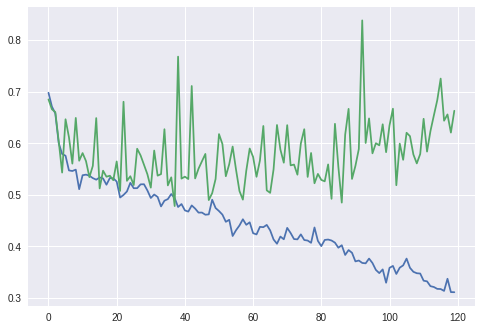

In [123]:
plt.plot(gru_mean_train_loss_history)
plt.plot(gru_mean_val_loss_history)

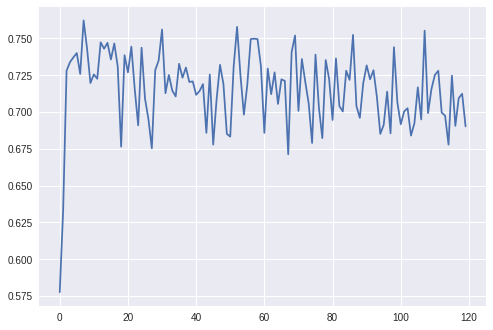

In [124]:
plt.plot(gru_mean_test_auc_history)

In [122]:
print("Best AUC: %.4f" % np.max([max(i) for i in gru_mean_test_auc_histories[:10]]))
print("Mean AUC: %.4f, Std: %.4f" % 
      (np.mean([max(i) for i in gru_mean_test_auc_histories]), 
       np.std([max(i) for i in gru_mean_test_auc_histories]))
     )

Best AUC: 0.7895
Mean AUC: 0.7628, Std: 0.0178


# GRU-Forward

In [0]:
def test_model_gru_forward(loader, model, concat_input=False):
    correct = 0
    total = 0
    model.eval()

    predictions = []
    truths = []
    
    total_loss = 0

    for data, label in loader:
        x, delta, m, x_forward, lengths = data

        sorted_lengths, sorted_idx = lengths.sort(descending=True)

        x = Variable(x[sorted_idx].float()).cuda()
        delta = Variable(delta[sorted_idx].float()).cuda()
        m = Variable(m[sorted_idx].float()).cuda()
        x_forward = Variable(x_forward[sorted_idx].float()).cuda()

        x[m.data.byte()] = x_forward[m.data.byte()]

        output = model(pack_padded_sequence(x, sorted_lengths.numpy(), batch_first=True))
        
        label = label[sorted_idx]
        loss = loss_func(output, Variable(label).cuda())
            
        total_loss += loss.data[0]
        predicted = (output.cpu().max(1)[1].data.long()).view(-1)
        predictions += list(predicted.numpy())
        truths += list(label)
        total += label.size(0)
        correct += (predicted == label).sum()

    model.train()

    return 100 * correct / total, roc_auc_score(truths, predictions), total_loss/len(loader)

In [125]:
gru_forward_train_loss_histories = []
gru_forward_test_auc_histories = []
gru_forward_val_loss_histories = []
gru_forward_val_acc_histories = []

for k in range(num_fold):
    train_ds.set_active_indices(train_dfs[k])
    test_ds.set_active_indices(test_dfs[k], new_means=train_ds.means, new_stds=train_ds.stds)
    train_loader = torch.utils.data.DataLoader(dataset=train_ds,
                                           batch_size=batch_size,
                                           collate_fn=dataset.PhysioNET.collate_batch,
                                           shuffle=True)
    test_loader = torch.utils.data.DataLoader(dataset=test_ds,
                                          batch_size=batch_size,
                                          collate_fn=dataset.PhysioNET.collate_batch,
                                          shuffle=True)

    gru_forward = GRU_decoder(NUM_FEATURES, hidden_size, output_size, 
                      gru_dropout, decoder_dropout)
    gru_forward.cuda()

    optimizer = torch.optim.Adam(gru_forward.parameters(), lr=1e-3)
    
    gru_forward_train_loss_history = []
    gru_forward_test_auc_history = []
    gru_forward_val_loss_history = []
    gru_forward_val_acc_history = []

    for epoch in range(num_epochs):
        start = time()
        total_loss = 0.

        for i, (data, label) in enumerate(train_loader):
            x, delta, m, x_forward, lengths = data

            sorted_lengths, sorted_idx = lengths.sort(descending=True)
            
            x = Variable(x[sorted_idx].float()).cuda()
            delta = Variable(delta[sorted_idx].float()).cuda()
            m = Variable(m[sorted_idx].float()).cuda()
            x_forward = Variable(x_forward[sorted_idx].float()).cuda()

            x[m.data.byte()] = x_forward[m.data.byte()]

            optimizer.zero_grad()

            output = gru_forward(pack_padded_sequence(x, sorted_lengths.numpy(), batch_first=True))

            loss = loss_func(output, Variable(label[sorted_idx].long()).cuda())
            loss.backward()
            optimizer.step()

            total_loss += loss.data[0]

            # report performance
            if (i + 1) % log_interval == 0:
                val_acc, test_auc, val_loss = test_model_gru_forward(test_loader, gru_forward)
                gru_forward_train_loss_history.append(total_loss/(i+1))
                gru_forward_test_auc_history.append(test_auc)
                gru_forward_val_acc_history.append(val_acc)
                gru_forward_val_loss_history.append(val_loss)
                print('Fold: {8}, Epoch: [{0}/{1}], Step: [{2}/{3}], Loss: {4}, Validation Loss:{5}, Validation Acc:{6}, AUC:{7}'.format(
                    epoch + 1, num_epochs, i + 1, len(train_loader), total_loss/(i+1), val_loss, val_acc, test_auc, k+1))
        print("Epoch %d time: %.4f" % (epoch, time()-start))

    gru_forward_train_loss_histories.append(gru_forward_train_loss_history)
    gru_forward_test_auc_histories.append(gru_forward_test_auc_history)
    gru_forward_val_loss_histories.append(gru_forward_val_loss_history)
    gru_forward_val_acc_histories.append(gru_forward_val_acc_history)

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Fold: 1, Epoch: [1/40], Step: [9/29], Loss: 0.6912558608584933, Validation Loss:0.6569111794233322, Validation Acc:69.32668329177058, AUC:0.6497153209109732
Fold: 1, Epoch: [1/40], Step: [18/29], Loss: 0.6490186386638217, Validation Loss:0.6138132959604263, Validation Acc:72.06982543640898, AUC:0.7180124223602485
Fold: 1, Epoch: [1/40], Step: [27/29], Loss: 0.617095360049495, Validation Loss:0.5512276068329811, Validation Acc:70.57356608478803, AUC:0.7242753623188406
Epoch 0 time: 2.0742
Fold: 1, Epoch: [2/40], Step: [9/29], Loss: 0.5314640071656969, Validation Loss:0.5452506467700005, Validation Acc:67.83042394014963, AUC:0.7307712215320912
Fold: 1, Epoch: [2/40], Step: [18/29], Loss: 0.5397722605201933, Validation Loss:0.616474412381649, Validation Acc:67.08229426433915, AUC:0.718944099378882
Fold: 1, Epoch: [2/40], Step: [27/29], Loss: 0.5306930354347935, Validation Loss:0.5028433203697205, Validation Acc:69.07730673316708, AUC:0.7454968944099378
Epoch 1 time: 1.9449
Fold: 1, Epoch:

Fold: 1, Epoch: [12/40], Step: [18/29], Loss: 0.40921059416400063, Validation Loss:0.5291879177093506, Validation Acc:70.82294264339153, AUC:0.7182453416149068
Fold: 1, Epoch: [12/40], Step: [27/29], Loss: 0.42032298666459544, Validation Loss:0.5844492763280869, Validation Acc:71.07231920199501, AUC:0.7196946169772257
Epoch 11 time: 1.9635
Fold: 1, Epoch: [13/40], Step: [9/29], Loss: 0.3824976748890347, Validation Loss:0.6015201359987259, Validation Acc:75.56109725685785, AUC:0.7383022774327123
Fold: 1, Epoch: [13/40], Step: [18/29], Loss: 0.4011077798075146, Validation Loss:0.5757630169391632, Validation Acc:74.3142144638404, AUC:0.731055900621118
Fold: 1, Epoch: [13/40], Step: [27/29], Loss: 0.41140612297587925, Validation Loss:0.5651413723826408, Validation Acc:72.56857855361596, AUC:0.7209109730848862
Epoch 12 time: 1.9566
Fold: 1, Epoch: [14/40], Step: [9/29], Loss: 0.3988104462623596, Validation Loss:0.5191020667552948, Validation Acc:72.06982543640898, AUC:0.7105331262939959
Fol

Fold: 1, Epoch: [23/40], Step: [27/29], Loss: 0.32042871746752, Validation Loss:0.7946431040763855, Validation Acc:75.31172069825436, AUC:0.6844979296066253
Epoch 22 time: 1.9927
Fold: 1, Epoch: [24/40], Step: [9/29], Loss: 0.29665739668740165, Validation Loss:0.8208629935979843, Validation Acc:75.31172069825436, AUC:0.6919772256728779
Fold: 1, Epoch: [24/40], Step: [18/29], Loss: 0.3027973514464166, Validation Loss:0.7591411471366882, Validation Acc:71.57107231920199, AUC:0.6627587991718428
Fold: 1, Epoch: [24/40], Step: [27/29], Loss: 0.3077485373726598, Validation Loss:0.6533182486891747, Validation Acc:72.56857855361596, AUC:0.6760351966873707
Epoch 23 time: 1.9913
Fold: 1, Epoch: [25/40], Step: [9/29], Loss: 0.2885007990731133, Validation Loss:0.7737295925617218, Validation Acc:74.56359102244389, AUC:0.6651915113871636
Fold: 1, Epoch: [25/40], Step: [18/29], Loss: 0.29580464048518074, Validation Loss:0.6738001704216003, Validation Acc:77.0573566084788, AUC:0.679684265010352
Fold: 

Fold: 1, Epoch: [35/40], Step: [9/29], Loss: 0.1717032425933414, Validation Loss:1.0590910613536835, Validation Acc:77.80548628428927, AUC:0.6541149068322981
Fold: 1, Epoch: [35/40], Step: [18/29], Loss: 0.17331144048107994, Validation Loss:0.9238729029893875, Validation Acc:75.56109725685785, AUC:0.6410714285714286
Fold: 1, Epoch: [35/40], Step: [27/29], Loss: 0.17222058441903856, Validation Loss:1.0409976840019226, Validation Acc:75.56109725685785, AUC:0.6111542443064182
Epoch 34 time: 1.9943
Fold: 1, Epoch: [36/40], Step: [9/29], Loss: 0.16357229153315225, Validation Loss:0.8504685834050179, Validation Acc:77.80548628428927, AUC:0.6765527950310558
Fold: 1, Epoch: [36/40], Step: [18/29], Loss: 0.17159437470965916, Validation Loss:0.9394032061100006, Validation Acc:76.05985037406484, AUC:0.6514492753623188
Fold: 1, Epoch: [36/40], Step: [27/29], Loss: 0.17225836079429696, Validation Loss:1.1130431294441223, Validation Acc:73.81546134663341, AUC:0.6384057971014493
Epoch 35 time: 1.9694

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Fold: 2, Epoch: [1/40], Step: [9/29], Loss: 0.6883715391159058, Validation Loss:0.655120849609375, Validation Acc:79.30174563591022, AUC:0.6927277432712216
Fold: 2, Epoch: [1/40], Step: [18/29], Loss: 0.6502097414599525, Validation Loss:0.5746204555034637, Validation Acc:77.55610972568579, AUC:0.7274585921325052
Fold: 2, Epoch: [1/40], Step: [27/29], Loss: 0.6219631135463715, Validation Loss:0.5593947768211365, Validation Acc:75.31172069825436, AUC:0.7368530020703935
Epoch 0 time: 1.9824
Fold: 2, Epoch: [2/40], Step: [9/29], Loss: 0.5296115246084001, Validation Loss:0.5264822840690613, Validation Acc:72.81795511221945, AUC:0.7298395445134574
Fold: 2, Epoch: [2/40], Step: [18/29], Loss: 0.5295815236038632, Validation Loss:0.527998298406601, Validation Acc:71.57107231920199, AUC:0.745031055900621
Fold: 2, Epoch: [2/40], Step: [27/29], Loss: 0.5376450529804936, Validation Loss:0.5783777311444283, Validation Acc:70.82294264339153, AUC:0.7556418219461697
Epoch 1 time: 1.9824
Fold: 2, Epoch:

Fold: 2, Epoch: [12/40], Step: [18/29], Loss: 0.436930634909206, Validation Loss:0.488810732960701, Validation Acc:74.3142144638404, AUC:0.7759316770186335
Fold: 2, Epoch: [12/40], Step: [27/29], Loss: 0.43625472872345533, Validation Loss:0.5216220691800117, Validation Acc:75.81047381546135, AUC:0.7846273291925465
Epoch 11 time: 2.0315
Fold: 2, Epoch: [13/40], Step: [9/29], Loss: 0.4373357660240597, Validation Loss:0.5746172219514847, Validation Acc:77.0573566084788, AUC:0.7843944099378882
Fold: 2, Epoch: [13/40], Step: [18/29], Loss: 0.42380958961115944, Validation Loss:0.5873330384492874, Validation Acc:75.56109725685785, AUC:0.7682194616977225
Fold: 2, Epoch: [13/40], Step: [27/29], Loss: 0.41966285970475936, Validation Loss:0.5987511053681374, Validation Acc:75.56109725685785, AUC:0.76074016563147
Epoch 12 time: 2.0113
Fold: 2, Epoch: [14/40], Step: [9/29], Loss: 0.38754041658507454, Validation Loss:0.5365887433290482, Validation Acc:77.0573566084788, AUC:0.7619565217391303
Fold: 2

Fold: 2, Epoch: [23/40], Step: [27/29], Loss: 0.3470921814441681, Validation Loss:0.5903094559907913, Validation Acc:76.80798004987531, AUC:0.7231107660455486
Epoch 22 time: 1.9793
Fold: 2, Epoch: [24/40], Step: [9/29], Loss: 0.3110935654905107, Validation Loss:0.6779312714934349, Validation Acc:78.55361596009975, AUC:0.7257763975155279
Fold: 2, Epoch: [24/40], Step: [18/29], Loss: 0.32247630258401233, Validation Loss:0.5967532098293304, Validation Acc:77.0573566084788, AUC:0.7245600414078675
Fold: 2, Epoch: [24/40], Step: [27/29], Loss: 0.3326618759720414, Validation Loss:0.5700784102082253, Validation Acc:78.05486284289277, AUC:0.7228778467908903
Epoch 23 time: 2.0038
Fold: 2, Epoch: [25/40], Step: [9/29], Loss: 0.3000051958693398, Validation Loss:0.5225240960717201, Validation Acc:79.05236907730674, AUC:0.7137163561076605
Fold: 2, Epoch: [25/40], Step: [18/29], Loss: 0.3179246162374814, Validation Loss:0.5921424627304077, Validation Acc:79.55112219451371, AUC:0.7315734989648033
Fold

Fold: 2, Epoch: [35/40], Step: [9/29], Loss: 0.2141808056169086, Validation Loss:0.755571261048317, Validation Acc:79.05236907730674, AUC:0.6912784679089027
Fold: 2, Epoch: [35/40], Step: [18/29], Loss: 0.20447476870483822, Validation Loss:0.6938890814781189, Validation Acc:80.0498753117207, AUC:0.7120341614906833
Fold: 2, Epoch: [35/40], Step: [27/29], Loss: 0.20954406592581007, Validation Loss:0.8171291351318359, Validation Acc:80.29925187032418, AUC:0.6985248447204969
Epoch 34 time: 1.9682
Fold: 2, Epoch: [36/40], Step: [9/29], Loss: 0.1894908050696055, Validation Loss:1.256307765841484, Validation Acc:81.29675810473816, AUC:0.6893633540372671
Fold: 2, Epoch: [36/40], Step: [18/29], Loss: 0.18618671347697577, Validation Loss:0.7912481650710106, Validation Acc:82.54364089775561, AUC:0.719047619047619
Fold: 2, Epoch: [36/40], Step: [27/29], Loss: 0.18713014600453554, Validation Loss:0.7789588123559952, Validation Acc:82.29426433915212, AUC:0.7175983436853002
Epoch 35 time: 1.9877
Fold

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Fold: 3, Epoch: [1/40], Step: [9/29], Loss: 0.701544808016883, Validation Loss:0.6366740614175797, Validation Acc:63.34164588528678, AUC:0.6897256728778467
Fold: 3, Epoch: [1/40], Step: [18/29], Loss: 0.6508993208408356, Validation Loss:0.5958560407161713, Validation Acc:70.57356608478803, AUC:0.7167960662525881
Fold: 3, Epoch: [1/40], Step: [27/29], Loss: 0.6281415036431065, Validation Loss:0.6048111319541931, Validation Acc:68.3291770573566, AUC:0.711231884057971
Epoch 0 time: 1.9863
Fold: 3, Epoch: [2/40], Step: [9/29], Loss: 0.5422672695583768, Validation Loss:0.549284391105175, Validation Acc:67.83042394014963, AUC:0.7158126293995859
Fold: 3, Epoch: [2/40], Step: [18/29], Loss: 0.5303132997618781, Validation Loss:0.5362729653716087, Validation Acc:69.07730673316708, AUC:0.7155797101449275
Fold: 3, Epoch: [2/40], Step: [27/29], Loss: 0.536182928968359, Validation Loss:0.5290656238794327, Validation Acc:70.07481296758105, AUC:0.7138975155279503
Epoch 1 time: 1.9769
Fold: 3, Epoch: [

Fold: 3, Epoch: [12/40], Step: [18/29], Loss: 0.4070543481243981, Validation Loss:0.47343859821558, Validation Acc:76.80798004987531, AUC:0.7829451345755694
Fold: 3, Epoch: [12/40], Step: [27/29], Loss: 0.4239314772464611, Validation Loss:0.4984486550092697, Validation Acc:77.55610972568579, AUC:0.7573757763975155
Epoch 11 time: 1.9754
Fold: 3, Epoch: [13/40], Step: [9/29], Loss: 0.4071637623839908, Validation Loss:0.5191812738776207, Validation Acc:75.31172069825436, AUC:0.7518115942028986
Fold: 3, Epoch: [13/40], Step: [18/29], Loss: 0.40889571772681343, Validation Loss:0.5017911046743393, Validation Acc:76.80798004987531, AUC:0.7605072463768117
Fold: 3, Epoch: [13/40], Step: [27/29], Loss: 0.407443478151604, Validation Loss:0.4724747762084007, Validation Acc:77.3067331670823, AUC:0.7634057971014493
Epoch 12 time: 1.9832
Fold: 3, Epoch: [14/40], Step: [9/29], Loss: 0.4063895410961575, Validation Loss:0.4516165480017662, Validation Acc:77.0573566084788, AUC:0.7619565217391303
Fold: 3,

Fold: 3, Epoch: [23/40], Step: [27/29], Loss: 0.295907492990847, Validation Loss:0.645946130156517, Validation Acc:77.55610972568579, AUC:0.7349378881987577
Epoch 22 time: 1.9995
Fold: 3, Epoch: [24/40], Step: [9/29], Loss: 0.2629606028397878, Validation Loss:0.5619351789355278, Validation Acc:75.81047381546135, AUC:0.7547101449275362
Fold: 3, Epoch: [24/40], Step: [18/29], Loss: 0.28623606264591217, Validation Loss:0.659294456243515, Validation Acc:74.56359102244389, AUC:0.7549430641821946
Fold: 3, Epoch: [24/40], Step: [27/29], Loss: 0.281036306310583, Validation Loss:0.5778498314321041, Validation Acc:77.55610972568579, AUC:0.7424171842650104
Epoch 23 time: 1.9863
Fold: 3, Epoch: [25/40], Step: [9/29], Loss: 0.26136780778567, Validation Loss:0.5409585386514664, Validation Acc:79.55112219451371, AUC:0.7540113871635611
Fold: 3, Epoch: [25/40], Step: [18/29], Loss: 0.26596685002247494, Validation Loss:0.8234086036682129, Validation Acc:79.80049875311721, AUC:0.7405020703933747
Fold: 3,

Fold: 3, Epoch: [35/40], Step: [9/29], Loss: 0.1448469642135832, Validation Loss:1.0521447658538818, Validation Acc:81.29675810473816, AUC:0.72675983436853
Fold: 3, Epoch: [35/40], Step: [18/29], Loss: 0.13431414465109506, Validation Loss:1.0207863450050354, Validation Acc:80.54862842892769, AUC:0.7373706004140786
Fold: 3, Epoch: [35/40], Step: [27/29], Loss: 0.13165741800158112, Validation Loss:1.289250686764717, Validation Acc:82.29426433915212, AUC:0.7250776397515529
Epoch 34 time: 2.0216
Fold: 3, Epoch: [36/40], Step: [9/29], Loss: 0.12029702299171025, Validation Loss:0.8416251465678215, Validation Acc:84.03990024937656, AUC:0.7352225672877848
Fold: 3, Epoch: [36/40], Step: [18/29], Loss: 0.13162759608692592, Validation Loss:0.7921601682901382, Validation Acc:80.0498753117207, AUC:0.7269927536231883
Fold: 3, Epoch: [36/40], Step: [27/29], Loss: 0.12431759470038944, Validation Loss:0.8733320981264114, Validation Acc:79.05236907730674, AUC:0.721195652173913
Epoch 35 time: 1.9830
Fold

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Fold: 4, Epoch: [1/40], Step: [9/29], Loss: 0.6353322201304965, Validation Loss:0.646671935915947, Validation Acc:67.33167082294264, AUC:0.6755175983436852
Fold: 4, Epoch: [1/40], Step: [18/29], Loss: 0.6138668855031332, Validation Loss:0.5913992375135422, Validation Acc:70.57356608478803, AUC:0.7093167701863353
Fold: 4, Epoch: [1/40], Step: [27/29], Loss: 0.5858673883808984, Validation Loss:0.567462146282196, Validation Acc:70.82294264339153, AUC:0.7257246376811594
Epoch 0 time: 1.9674
Fold: 4, Epoch: [2/40], Step: [9/29], Loss: 0.5427635080284543, Validation Loss:0.5698417127132416, Validation Acc:71.07231920199501, AUC:0.7196946169772257
Fold: 4, Epoch: [2/40], Step: [18/29], Loss: 0.5227116197347641, Validation Loss:0.5643634647130966, Validation Acc:71.07231920199501, AUC:0.7122153209109732
Fold: 4, Epoch: [2/40], Step: [27/29], Loss: 0.5205555701697314, Validation Loss:0.5631855204701424, Validation Acc:72.06982543640898, AUC:0.7254917184265011
Epoch 1 time: 1.9695
Fold: 4, Epoch

Fold: 4, Epoch: [12/40], Step: [18/29], Loss: 0.42536669307284886, Validation Loss:0.5390901267528534, Validation Acc:75.31172069825436, AUC:0.7518115942028986
Fold: 4, Epoch: [12/40], Step: [27/29], Loss: 0.4129730893505944, Validation Loss:0.6730941757559776, Validation Acc:74.56359102244389, AUC:0.7325051759834369
Epoch 11 time: 1.9752
Fold: 4, Epoch: [13/40], Step: [9/29], Loss: 0.4182065659099155, Validation Loss:0.5537313222885132, Validation Acc:77.55610972568579, AUC:0.7424171842650104
Fold: 4, Epoch: [13/40], Step: [18/29], Loss: 0.42282159129778546, Validation Loss:0.5269138664007187, Validation Acc:76.80798004987531, AUC:0.7305900621118013
Fold: 4, Epoch: [13/40], Step: [27/29], Loss: 0.4096852022188681, Validation Loss:0.5275447443127632, Validation Acc:76.30922693266832, AUC:0.7276915113871636
Epoch 12 time: 1.9402
Fold: 4, Epoch: [14/40], Step: [9/29], Loss: 0.4049089286062453, Validation Loss:0.6260179132223129, Validation Acc:75.06234413965088, AUC:0.7428830227743272
Fo

Fold: 4, Epoch: [23/40], Step: [27/29], Loss: 0.3020706171238864, Validation Loss:0.5663463994860649, Validation Acc:78.30423940149626, AUC:0.7318064182194617
Epoch 22 time: 2.0201
Fold: 4, Epoch: [24/40], Step: [9/29], Loss: 0.2936828268898858, Validation Loss:0.635952815413475, Validation Acc:77.80548628428927, AUC:0.7139492753623189
Fold: 4, Epoch: [24/40], Step: [18/29], Loss: 0.2982679042551253, Validation Loss:0.6316420286893845, Validation Acc:77.3067331670823, AUC:0.7035714285714286
Fold: 4, Epoch: [24/40], Step: [27/29], Loss: 0.300178787222615, Validation Loss:0.6834622174501419, Validation Acc:78.05486284289277, AUC:0.7153985507246376
Epoch 23 time: 2.0186
Fold: 4, Epoch: [25/40], Step: [9/29], Loss: 0.2830113073190053, Validation Loss:0.9017034620046616, Validation Acc:79.80049875311721, AUC:0.7105848861283645
Fold: 4, Epoch: [25/40], Step: [18/29], Loss: 0.27301784522003597, Validation Loss:0.803853452205658, Validation Acc:80.0498753117207, AUC:0.7269927536231883
Fold: 4,

Fold: 4, Epoch: [35/40], Step: [9/29], Loss: 0.11953088061677085, Validation Loss:0.8403369933366776, Validation Acc:81.29675810473816, AUC:0.7192805383022776
Fold: 4, Epoch: [35/40], Step: [18/29], Loss: 0.12489807688527638, Validation Loss:1.2748801410198212, Validation Acc:82.04488778054863, AUC:0.6787525879917184
Fold: 4, Epoch: [35/40], Step: [27/29], Loss: 0.12520216239823234, Validation Loss:0.984127089381218, Validation Acc:80.29925187032418, AUC:0.6686076604554866
Epoch 34 time: 1.9784
Fold: 4, Epoch: [36/40], Step: [9/29], Loss: 0.11030816576547092, Validation Loss:0.961438000202179, Validation Acc:79.05236907730674, AUC:0.6912784679089027
Fold: 4, Epoch: [36/40], Step: [18/29], Loss: 0.13410030657218563, Validation Loss:1.337429478764534, Validation Acc:81.54613466334165, AUC:0.6982919254658384
Fold: 4, Epoch: [36/40], Step: [27/29], Loss: 0.14029821436162349, Validation Loss:1.2280049175024033, Validation Acc:82.7930174563591, AUC:0.7130175983436853
Epoch 35 time: 1.9977
Fo

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Fold: 5, Epoch: [1/40], Step: [9/29], Loss: 0.6796833674112955, Validation Loss:0.6437118500471115, Validation Acc:67.0, AUC:0.7246376811594202
Fold: 5, Epoch: [1/40], Step: [18/29], Loss: 0.639765116903517, Validation Loss:0.5629177317023277, Validation Acc:74.0, AUC:0.7575757575757576
Fold: 5, Epoch: [1/40], Step: [27/29], Loss: 0.6152426158940351, Validation Loss:0.5513497963547707, Validation Acc:75.25, AUC:0.7648221343873517
Epoch 0 time: 1.9759
Fold: 5, Epoch: [2/40], Step: [9/29], Loss: 0.5172710915406545, Validation Loss:0.49256809055805206, Validation Acc:74.0, AUC:0.7499341238471674
Fold: 5, Epoch: [2/40], Step: [18/29], Loss: 0.5445963856246736, Validation Loss:0.5093178674578667, Validation Acc:74.0, AUC:0.7499341238471674
Fold: 5, Epoch: [2/40], Step: [27/29], Loss: 0.5444248528392227, Validation Loss:0.5221119895577431, Validation Acc:74.75, AUC:0.7466403162055336
Epoch 1 time: 1.9589
Fold: 5, Epoch: [3/40], Step: [9/29], Loss: 0.5059322946601443, Validation Loss:0.485427

Fold: 5, Epoch: [12/40], Step: [27/29], Loss: 0.43633654713630676, Validation Loss:0.5954433977603912, Validation Acc:76.0, AUC:0.7462450592885377
Epoch 11 time: 1.9804
Fold: 5, Epoch: [13/40], Step: [9/29], Loss: 0.44480568170547485, Validation Loss:0.4415273740887642, Validation Acc:75.75, AUC:0.7447957839262187
Fold: 5, Epoch: [13/40], Step: [18/29], Loss: 0.43822933236757916, Validation Loss:0.48587897419929504, Validation Acc:76.75, AUC:0.7658761528326746
Fold: 5, Epoch: [13/40], Step: [27/29], Loss: 0.4219100166250158, Validation Loss:0.4923290014266968, Validation Acc:76.0, AUC:0.7691699604743082
Epoch 12 time: 1.9849
Fold: 5, Epoch: [14/40], Step: [9/29], Loss: 0.4067094094223446, Validation Loss:0.4674277976155281, Validation Acc:79.25, AUC:0.7650856389986824
Fold: 5, Epoch: [14/40], Step: [18/29], Loss: 0.4113010780678855, Validation Loss:0.4657614380121231, Validation Acc:81.25, AUC:0.7613965744400527
Fold: 5, Epoch: [14/40], Step: [27/29], Loss: 0.4185751235043561, Validati

Fold: 5, Epoch: [24/40], Step: [18/29], Loss: 0.3317714316977395, Validation Loss:0.5775044858455658, Validation Acc:72.75, AUC:0.7121212121212123
Fold: 5, Epoch: [24/40], Step: [27/29], Loss: 0.33933236532741123, Validation Loss:0.5504928156733513, Validation Acc:77.0, AUC:0.7596837944664032
Epoch 23 time: 1.9851
Fold: 5, Epoch: [25/40], Step: [9/29], Loss: 0.32980528639422524, Validation Loss:0.5243633463978767, Validation Acc:79.0, AUC:0.7407114624505929
Fold: 5, Epoch: [25/40], Step: [18/29], Loss: 0.3250005402498775, Validation Loss:0.6123516485095024, Validation Acc:77.75, AUC:0.7411067193675889
Fold: 5, Epoch: [25/40], Step: [27/29], Loss: 0.32254862509391924, Validation Loss:0.5000912360846996, Validation Acc:78.5, AUC:0.791304347826087
Epoch 24 time: 1.9984
Fold: 5, Epoch: [26/40], Step: [9/29], Loss: 0.317599344584677, Validation Loss:0.553213931620121, Validation Acc:77.25, AUC:0.7611330698287221
Fold: 5, Epoch: [26/40], Step: [18/29], Loss: 0.31281917211082244, Validation L

Fold: 5, Epoch: [36/40], Step: [9/29], Loss: 0.18909665279918247, Validation Loss:0.906574085354805, Validation Acc:81.25, AUC:0.7231884057971014
Fold: 5, Epoch: [36/40], Step: [18/29], Loss: 0.1963732060458925, Validation Loss:0.7936539724469185, Validation Acc:79.5, AUC:0.697760210803689
Fold: 5, Epoch: [36/40], Step: [27/29], Loss: 0.19264167105710064, Validation Loss:1.049040898680687, Validation Acc:79.5, AUC:0.7130434782608697
Epoch 35 time: 1.9711
Fold: 5, Epoch: [37/40], Step: [9/29], Loss: 0.1759079173207283, Validation Loss:1.1996884644031525, Validation Acc:80.25, AUC:0.7097496706192359
Fold: 5, Epoch: [37/40], Step: [18/29], Loss: 0.17111668694350454, Validation Loss:1.0595375895500183, Validation Acc:78.25, AUC:0.6981554677206852
Fold: 5, Epoch: [37/40], Step: [27/29], Loss: 0.17178112792747993, Validation Loss:0.8347408175468445, Validation Acc:79.25, AUC:0.68866930171278
Epoch 36 time: 1.9816
Fold: 5, Epoch: [38/40], Step: [9/29], Loss: 0.1585250207119518, Validation Los

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Fold: 6, Epoch: [1/40], Step: [9/29], Loss: 0.6716341508759393, Validation Loss:0.6593283116817474, Validation Acc:72.5, AUC:0.6342555994729907
Fold: 6, Epoch: [1/40], Step: [18/29], Loss: 0.6392578250832028, Validation Loss:0.5907562226057053, Validation Acc:72.75, AUC:0.7121212121212123
Fold: 6, Epoch: [1/40], Step: [27/29], Loss: 0.6197854368774979, Validation Loss:0.556463211774826, Validation Acc:72.0, AUC:0.7230566534914361
Epoch 0 time: 1.9884
Fold: 6, Epoch: [2/40], Step: [9/29], Loss: 0.5483770569165548, Validation Loss:0.5652511566877365, Validation Acc:67.5, AUC:0.7198945981554676
Fold: 6, Epoch: [2/40], Step: [18/29], Loss: 0.5435418122344546, Validation Loss:0.5387541279196739, Validation Acc:67.75, AUC:0.7213438735177865
Fold: 6, Epoch: [2/40], Step: [27/29], Loss: 0.5403035967438309, Validation Loss:0.5507407709956169, Validation Acc:70.0, AUC:0.7114624505928854
Epoch 1 time: 1.9849
Fold: 6, Epoch: [3/40], Step: [9/29], Loss: 0.5477733247809939, Validation Loss:0.4890766

Fold: 6, Epoch: [12/40], Step: [27/29], Loss: 0.40552902111300715, Validation Loss:0.6164166927337646, Validation Acc:75.75, AUC:0.7600790513833993
Epoch 11 time: 1.9767
Fold: 6, Epoch: [13/40], Step: [9/29], Loss: 0.3916052149401771, Validation Loss:0.5762092396616936, Validation Acc:75.75, AUC:0.7065876152832674
Fold: 6, Epoch: [13/40], Step: [18/29], Loss: 0.398213740852144, Validation Loss:0.5433705225586891, Validation Acc:74.25, AUC:0.713175230566535
Fold: 6, Epoch: [13/40], Step: [27/29], Loss: 0.39864015579223633, Validation Loss:0.47637294605374336, Validation Acc:73.0, AUC:0.7212121212121212
Epoch 12 time: 1.9683
Fold: 6, Epoch: [14/40], Step: [9/29], Loss: 0.4001469512780507, Validation Loss:0.6246930733323097, Validation Acc:72.75, AUC:0.7121212121212123
Fold: 6, Epoch: [14/40], Step: [18/29], Loss: 0.3969770189788606, Validation Loss:0.47816693037748337, Validation Acc:72.0, AUC:0.7306982872200264
Fold: 6, Epoch: [14/40], Step: [27/29], Loss: 0.3913831412792206, Validation

Fold: 6, Epoch: [24/40], Step: [18/29], Loss: 0.2644685498542256, Validation Loss:0.7586672455072403, Validation Acc:79.5, AUC:0.6901185770750988
Fold: 6, Epoch: [24/40], Step: [27/29], Loss: 0.2721180612290347, Validation Loss:1.0003237128257751, Validation Acc:78.0, AUC:0.6814229249011857
Epoch 23 time: 1.9775
Fold: 6, Epoch: [25/40], Step: [9/29], Loss: 0.2622603293922212, Validation Loss:0.7384486421942711, Validation Acc:79.0, AUC:0.7101449275362319
Fold: 6, Epoch: [25/40], Step: [18/29], Loss: 0.2543814107775688, Validation Loss:0.7964230626821518, Validation Acc:80.5, AUC:0.6959156785243741
Fold: 6, Epoch: [25/40], Step: [27/29], Loss: 0.25464116588786795, Validation Loss:0.9080393463373184, Validation Acc:80.75, AUC:0.697364953886693
Epoch 24 time: 1.9787
Fold: 6, Epoch: [26/40], Step: [9/29], Loss: 0.22561556928687626, Validation Loss:1.0206004679203033, Validation Acc:75.0, AUC:0.6563899868247695
Fold: 6, Epoch: [26/40], Step: [18/29], Loss: 0.2536109470658832, Validation Los

Fold: 6, Epoch: [36/40], Step: [9/29], Loss: 0.12642885165082085, Validation Loss:1.5938231348991394, Validation Acc:80.75, AUC:0.6820816864295125
Fold: 6, Epoch: [36/40], Step: [18/29], Loss: 0.12393365303675334, Validation Loss:1.129671186208725, Validation Acc:82.25, AUC:0.6678524374176549
Fold: 6, Epoch: [36/40], Step: [27/29], Loss: 0.12725243220726648, Validation Loss:1.2132637798786163, Validation Acc:83.25, AUC:0.6736495388669302
Epoch 35 time: 1.9911
Fold: 6, Epoch: [37/40], Step: [9/29], Loss: 0.09181725854674976, Validation Loss:1.1627579554915428, Validation Acc:80.25, AUC:0.656258234519104
Fold: 6, Epoch: [37/40], Step: [18/29], Loss: 0.09851176974674065, Validation Loss:1.5442547798156738, Validation Acc:82.25, AUC:0.6525691699604743
Fold: 6, Epoch: [37/40], Step: [27/29], Loss: 0.09467919805535564, Validation Loss:1.4371928870677948, Validation Acc:82.75, AUC:0.655467720685112
Epoch 36 time: 1.9812
Fold: 6, Epoch: [38/40], Step: [9/29], Loss: 0.09948690897888607, Validat

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Fold: 7, Epoch: [1/40], Step: [9/29], Loss: 0.650065905518002, Validation Loss:0.6512775272130966, Validation Acc:72.18045112781955, AUC:0.6477272727272727
Fold: 7, Epoch: [1/40], Step: [18/29], Loss: 0.6187446580992805, Validation Loss:0.5673056468367577, Validation Acc:72.93233082706767, AUC:0.7208245243128963
Fold: 7, Epoch: [1/40], Step: [27/29], Loss: 0.6075213297649666, Validation Loss:0.5367090478539467, Validation Acc:72.93233082706767, AUC:0.7284619450317125
Epoch 0 time: 1.9877
Fold: 7, Epoch: [2/40], Step: [9/29], Loss: 0.5103562341796027, Validation Loss:0.55821792781353, Validation Acc:71.67919799498746, AUC:0.7364693446088795
Fold: 7, Epoch: [2/40], Step: [18/29], Loss: 0.5271779944499334, Validation Loss:0.48875217139720917, Validation Acc:72.93233082706767, AUC:0.7437367864693445
Fold: 7, Epoch: [2/40], Step: [27/29], Loss: 0.5350604962419581, Validation Loss:0.5411014780402184, Validation Acc:70.67669172932331, AUC:0.7306553911205074
Epoch 1 time: 1.9930
Fold: 7, Epoch

Fold: 7, Epoch: [12/40], Step: [18/29], Loss: 0.4333707226647271, Validation Loss:0.459086112678051, Validation Acc:77.19298245614036, AUC:0.76080866807611
Fold: 7, Epoch: [12/40], Step: [27/29], Loss: 0.42585459461918584, Validation Loss:0.4862659424543381, Validation Acc:74.93734335839599, AUC:0.7859143763213531
Epoch 11 time: 1.9832
Fold: 7, Epoch: [13/40], Step: [9/29], Loss: 0.4076017869843377, Validation Loss:0.4521505907177925, Validation Acc:79.69924812030075, AUC:0.7677061310782242
Fold: 7, Epoch: [13/40], Step: [18/29], Loss: 0.41064438554975724, Validation Loss:0.48899806290864944, Validation Acc:79.19799498746868, AUC:0.7724365750528541
Fold: 7, Epoch: [13/40], Step: [27/29], Loss: 0.41841334214916936, Validation Loss:0.41811956092715263, Validation Acc:76.69172932330827, AUC:0.7808139534883721
Epoch 12 time: 2.0221
Fold: 7, Epoch: [14/40], Step: [9/29], Loss: 0.415748483604855, Validation Loss:0.4991399794816971, Validation Acc:76.94235588972431, AUC:0.766992600422833
Fold

Fold: 7, Epoch: [23/40], Step: [27/29], Loss: 0.31501265256493177, Validation Loss:0.7035250663757324, Validation Acc:79.19799498746868, AUC:0.7571617336152219
Epoch 22 time: 1.9692
Fold: 7, Epoch: [24/40], Step: [9/29], Loss: 0.31774792406294083, Validation Loss:0.7723073661327362, Validation Acc:79.19799498746868, AUC:0.74188689217759
Fold: 7, Epoch: [24/40], Step: [18/29], Loss: 0.34276078475846183, Validation Loss:0.655981570482254, Validation Acc:78.69674185463658, AUC:0.7695295983086681
Fold: 7, Epoch: [24/40], Step: [27/29], Loss: 0.33102617219642355, Validation Loss:0.6217847615480423, Validation Acc:77.19298245614036, AUC:0.7378964059196618
Epoch 23 time: 1.9793
Fold: 7, Epoch: [25/40], Step: [9/29], Loss: 0.3000805659426583, Validation Loss:0.8477342426776886, Validation Acc:79.19799498746868, AUC:0.6884249471458774
Fold: 7, Epoch: [25/40], Step: [18/29], Loss: 0.3015717342495918, Validation Loss:0.7060779705643654, Validation Acc:80.70175438596492, AUC:0.7429704016913319
Fol

Fold: 7, Epoch: [35/40], Step: [9/29], Loss: 0.1581978334320916, Validation Loss:0.9682429879903793, Validation Acc:80.20050125313283, AUC:0.6560517970401691
Fold: 7, Epoch: [35/40], Step: [18/29], Loss: 0.1631162220405208, Validation Loss:0.9021141976118088, Validation Acc:80.95238095238095, AUC:0.6527748414376321
Fold: 7, Epoch: [35/40], Step: [27/29], Loss: 0.1566838064679393, Validation Loss:1.0881555080413818, Validation Acc:81.70426065162907, AUC:0.6724101479915433
Epoch 34 time: 1.9803
Fold: 7, Epoch: [36/40], Step: [9/29], Loss: 0.13361738787757027, Validation Loss:0.9649168252944946, Validation Acc:80.95238095238095, AUC:0.6680496828752642
Fold: 7, Epoch: [36/40], Step: [18/29], Loss: 0.13123443060451084, Validation Loss:1.0224681496620178, Validation Acc:81.70426065162907, AUC:0.6647727272727273
Fold: 7, Epoch: [36/40], Step: [27/29], Loss: 0.13338772649014438, Validation Loss:1.177668035030365, Validation Acc:78.94736842105263, AUC:0.65642177589852
Epoch 35 time: 1.9768
Fold

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Fold: 8, Epoch: [1/40], Step: [9/29], Loss: 0.6696984900368584, Validation Loss:0.6519713997840881, Validation Acc:64.91228070175438, AUC:0.6590380549682876
Fold: 8, Epoch: [1/40], Step: [18/29], Loss: 0.6442987322807312, Validation Loss:0.6178998351097107, Validation Acc:69.67418546365914, AUC:0.686654334038055
Fold: 8, Epoch: [1/40], Step: [27/29], Loss: 0.6232574162659822, Validation Loss:0.5342147722840309, Validation Acc:67.91979949874687, AUC:0.7070295983086683
Epoch 0 time: 1.9665
Fold: 8, Epoch: [2/40], Step: [9/29], Loss: 0.5340674850675795, Validation Loss:0.6081254482269287, Validation Acc:67.16791979949875, AUC:0.7179439746300212
Fold: 8, Epoch: [2/40], Step: [18/29], Loss: 0.537108204431004, Validation Loss:0.5357119292020798, Validation Acc:67.91979949874687, AUC:0.7223044397463002
Fold: 8, Epoch: [2/40], Step: [27/29], Loss: 0.5342066177615413, Validation Loss:0.5565975457429886, Validation Acc:68.42105263157895, AUC:0.7175739957716702
Epoch 1 time: 1.9883
Fold: 8, Epoch

Fold: 8, Epoch: [12/40], Step: [18/29], Loss: 0.41430558760960895, Validation Loss:0.49318827688694, Validation Acc:72.93233082706767, AUC:0.7360993657505285
Fold: 8, Epoch: [12/40], Step: [27/29], Loss: 0.41949216304001985, Validation Loss:0.5270381346344948, Validation Acc:73.6842105263158, AUC:0.7557346723044397
Epoch 11 time: 2.0000
Fold: 8, Epoch: [13/40], Step: [9/29], Loss: 0.3930242525206672, Validation Loss:0.53511643409729, Validation Acc:74.43609022556392, AUC:0.7295454545454545
Fold: 8, Epoch: [13/40], Step: [18/29], Loss: 0.4155591130256653, Validation Loss:0.4816332310438156, Validation Acc:75.18796992481202, AUC:0.7491807610993658
Fold: 8, Epoch: [13/40], Step: [27/29], Loss: 0.4122665723164876, Validation Loss:0.4361652322113514, Validation Acc:73.43358395989975, AUC:0.7237315010570824
Epoch 12 time: 1.9591
Fold: 8, Epoch: [14/40], Step: [9/29], Loss: 0.4045919742849138, Validation Loss:0.43818484246730804, Validation Acc:74.68671679197995, AUC:0.7386363636363636
Fold: 

Fold: 8, Epoch: [23/40], Step: [27/29], Loss: 0.299701107872857, Validation Loss:0.5289529673755169, Validation Acc:75.18796992481202, AUC:0.6880813953488373
Epoch 22 time: 1.9769
Fold: 8, Epoch: [24/40], Step: [9/29], Loss: 0.2723090731435352, Validation Loss:0.5930287912487984, Validation Acc:79.19799498746868, AUC:0.6960623678646934
Fold: 8, Epoch: [24/40], Step: [18/29], Loss: 0.27299730148580337, Validation Loss:0.5969082750380039, Validation Acc:76.69172932330827, AUC:0.6738900634249471
Fold: 8, Epoch: [24/40], Step: [27/29], Loss: 0.2854371849033568, Validation Loss:0.5645793676376343, Validation Acc:75.18796992481202, AUC:0.6957188160676533
Epoch 23 time: 1.9715
Fold: 8, Epoch: [25/40], Step: [9/29], Loss: 0.2835395799742805, Validation Loss:0.5513888746500015, Validation Acc:76.44110275689223, AUC:0.7335359408033827
Fold: 8, Epoch: [25/40], Step: [18/29], Loss: 0.29644012120034957, Validation Loss:0.5166234541684389, Validation Acc:73.93483709273183, AUC:0.7037262156448203
Fol

Fold: 8, Epoch: [35/40], Step: [9/29], Loss: 0.1421410996052954, Validation Loss:1.0935319364070892, Validation Acc:83.95989974937343, AUC:0.6778541226215645
Fold: 8, Epoch: [35/40], Step: [18/29], Loss: 0.1354619926876492, Validation Loss:0.8211340717971325, Validation Acc:81.70426065162907, AUC:0.6571353065539112
Fold: 8, Epoch: [35/40], Step: [27/29], Loss: 0.1418214961886406, Validation Loss:0.8970738053321838, Validation Acc:80.95238095238095, AUC:0.6680496828752642
Epoch 34 time: 1.9591
Fold: 8, Epoch: [36/40], Step: [9/29], Loss: 0.1319979793495602, Validation Loss:0.8686988428235054, Validation Acc:83.70927318295739, AUC:0.6840380549682875
Fold: 8, Epoch: [36/40], Step: [18/29], Loss: 0.13731163491805395, Validation Loss:1.002640277147293, Validation Acc:82.95739348370927, AUC:0.6491279069767442
Fold: 8, Epoch: [36/40], Step: [27/29], Loss: 0.13545650547301327, Validation Loss:1.0428577214479446, Validation Acc:82.70676691729324, AUC:0.6705866807610994
Epoch 35 time: 1.9558
Fol

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Fold: 9, Epoch: [1/40], Step: [9/29], Loss: 0.6736121641265022, Validation Loss:0.6569283902645111, Validation Acc:78.19548872180451, AUC:0.6367864693446088
Fold: 9, Epoch: [1/40], Step: [18/29], Loss: 0.6321336229642233, Validation Loss:0.6269540935754776, Validation Acc:74.68671679197995, AUC:0.7004492600422833
Fold: 9, Epoch: [1/40], Step: [27/29], Loss: 0.6103350155883365, Validation Loss:0.5629214942455292, Validation Acc:72.43107769423558, AUC:0.6950052854122621
Epoch 0 time: 2.0167
Fold: 9, Epoch: [2/40], Step: [9/29], Loss: 0.5465873115592532, Validation Loss:0.5276937857270241, Validation Acc:70.42606516290726, AUC:0.7215644820295983
Fold: 9, Epoch: [2/40], Step: [18/29], Loss: 0.5263380308945974, Validation Loss:0.5260047987103462, Validation Acc:73.1829573934837, AUC:0.7451902748414376
Fold: 9, Epoch: [2/40], Step: [27/29], Loss: 0.5309814733487589, Validation Loss:0.5859098508954048, Validation Acc:72.43107769423558, AUC:0.7331923890063425
Epoch 1 time: 1.9890
Fold: 9, Epoc

Fold: 9, Epoch: [12/40], Step: [18/29], Loss: 0.4180173807673984, Validation Loss:0.4598902240395546, Validation Acc:75.43859649122807, AUC:0.765909090909091
Fold: 9, Epoch: [12/40], Step: [27/29], Loss: 0.4284043003011633, Validation Loss:0.553376168012619, Validation Acc:76.94235588972431, AUC:0.766992600422833
Epoch 11 time: 1.9603
Fold: 9, Epoch: [13/40], Step: [9/29], Loss: 0.4203322794702318, Validation Loss:0.6201809197664261, Validation Acc:79.9498746867168, AUC:0.7691596194503171
Fold: 9, Epoch: [13/40], Step: [18/29], Loss: 0.4150671280092663, Validation Loss:0.4978117123246193, Validation Acc:78.94736842105263, AUC:0.7709830866807612
Fold: 9, Epoch: [13/40], Step: [27/29], Loss: 0.406768097921654, Validation Loss:0.5682880133390427, Validation Acc:77.69423558897243, AUC:0.75607822410148
Epoch 12 time: 1.9649
Fold: 9, Epoch: [14/40], Step: [9/29], Loss: 0.3781947195529938, Validation Loss:0.4677891656756401, Validation Acc:78.44611528822055, AUC:0.7298890063424947
Fold: 9, Ep

Fold: 9, Epoch: [23/40], Step: [27/29], Loss: 0.29170051879352993, Validation Loss:0.6334417834877968, Validation Acc:80.20050125313283, AUC:0.7400634249471458
Epoch 22 time: 1.9845
Fold: 9, Epoch: [24/40], Step: [9/29], Loss: 0.2885088523228963, Validation Loss:0.6248004734516144, Validation Acc:77.69423558897243, AUC:0.7331659619450318
Fold: 9, Epoch: [24/40], Step: [18/29], Loss: 0.2963971305224631, Validation Loss:0.7133083045482635, Validation Acc:78.69674185463658, AUC:0.7389799154334039
Fold: 9, Epoch: [24/40], Step: [27/29], Loss: 0.29072883283650436, Validation Loss:0.5689352676272392, Validation Acc:81.45363408521304, AUC:0.7396934460887948
Epoch 23 time: 1.9841
Fold: 9, Epoch: [25/40], Step: [9/29], Loss: 0.27042947047286564, Validation Loss:0.78773233294487, Validation Acc:80.20050125313283, AUC:0.7324260042283297
Fold: 9, Epoch: [25/40], Step: [18/29], Loss: 0.27275944501161575, Validation Loss:0.5494852177798748, Validation Acc:81.45363408521304, AUC:0.747330866807611
Fol

Fold: 9, Epoch: [35/40], Step: [9/29], Loss: 0.14841111914979088, Validation Loss:0.8970371931791306, Validation Acc:81.95488721804512, AUC:0.6891384778012685
Fold: 9, Epoch: [35/40], Step: [18/29], Loss: 0.14761063994632828, Validation Loss:1.17062246799469, Validation Acc:82.20551378446115, AUC:0.6600422832980972
Fold: 9, Epoch: [35/40], Step: [27/29], Loss: 0.13922120299604204, Validation Loss:0.8658620193600655, Validation Acc:83.45864661654136, AUC:0.6902219873150106
Epoch 34 time: 1.9754
Fold: 9, Epoch: [36/40], Step: [9/29], Loss: 0.12962564991580117, Validation Loss:0.9476313441991806, Validation Acc:80.20050125313283, AUC:0.6713266384778013
Fold: 9, Epoch: [36/40], Step: [18/29], Loss: 0.1364925280213356, Validation Loss:0.7966097984462976, Validation Acc:81.95488721804512, AUC:0.6891384778012685
Fold: 9, Epoch: [36/40], Step: [27/29], Loss: 0.13523627514088596, Validation Loss:0.8953332826495171, Validation Acc:82.95739348370927, AUC:0.6720401691331924
Epoch 35 time: 1.9781
F

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Fold: 10, Epoch: [1/40], Step: [9/29], Loss: 0.6225320961740282, Validation Loss:0.6420807391405106, Validation Acc:76.94235588972431, AUC:0.7288054968287527
Fold: 10, Epoch: [1/40], Step: [18/29], Loss: 0.6160288585556878, Validation Loss:0.5512501373887062, Validation Acc:75.43859649122807, AUC:0.7277219873150106
Fold: 10, Epoch: [1/40], Step: [27/29], Loss: 0.5882063364541089, Validation Loss:0.5059917941689491, Validation Acc:76.44110275689223, AUC:0.7488107822410148
Epoch 0 time: 1.9532
Fold: 10, Epoch: [2/40], Step: [9/29], Loss: 0.5152785016430749, Validation Loss:0.5538319945335388, Validation Acc:75.43859649122807, AUC:0.765909090909091
Fold: 10, Epoch: [2/40], Step: [18/29], Loss: 0.5181636297040515, Validation Loss:0.4732418581843376, Validation Acc:75.18796992481202, AUC:0.7415433403805497
Fold: 10, Epoch: [2/40], Step: [27/29], Loss: 0.5250867185769258, Validation Loss:0.5387229695916176, Validation Acc:74.43609022556392, AUC:0.7295454545454545
Epoch 1 time: 1.9794
Fold: 1

Fold: 10, Epoch: [12/40], Step: [18/29], Loss: 0.4248755027850469, Validation Loss:0.5260873213410378, Validation Acc:80.20050125313283, AUC:0.7553382663847781
Fold: 10, Epoch: [12/40], Step: [27/29], Loss: 0.4149392467957956, Validation Loss:0.4697164446115494, Validation Acc:76.44110275689223, AUC:0.7488107822410148
Epoch 11 time: 1.9957
Fold: 10, Epoch: [13/40], Step: [9/29], Loss: 0.42053870691193473, Validation Loss:0.4332958832383156, Validation Acc:76.44110275689223, AUC:0.756448202959831
Fold: 10, Epoch: [13/40], Step: [18/29], Loss: 0.41595039930608535, Validation Loss:0.6428600922226906, Validation Acc:76.44110275689223, AUC:0.7488107822410148
Fold: 10, Epoch: [13/40], Step: [27/29], Loss: 0.41239175973115144, Validation Loss:0.5158121213316917, Validation Acc:78.44611528822055, AUC:0.7451638477801268
Epoch 12 time: 1.9819
Fold: 10, Epoch: [14/40], Step: [9/29], Loss: 0.3864024049705929, Validation Loss:0.5471866801381111, Validation Acc:77.44360902255639, AUC:0.7622621564482

Fold: 10, Epoch: [23/40], Step: [27/29], Loss: 0.29352679407155075, Validation Loss:0.6756426841020584, Validation Acc:77.94486215538848, AUC:0.6964323467230443
Epoch 22 time: 1.9826
Fold: 10, Epoch: [24/40], Step: [9/29], Loss: 0.27513547903961605, Validation Loss:0.6250706613063812, Validation Acc:78.19548872180451, AUC:0.7055232558139535
Fold: 10, Epoch: [24/40], Step: [18/29], Loss: 0.2747253618306584, Validation Loss:0.5700031537562609, Validation Acc:79.4486215538847, AUC:0.7127906976744186
Fold: 10, Epoch: [24/40], Step: [27/29], Loss: 0.2824798872073491, Validation Loss:0.6417055577039719, Validation Acc:79.4486215538847, AUC:0.7433403805496829
Epoch 23 time: 1.9789
Fold: 10, Epoch: [25/40], Step: [9/29], Loss: 0.28998840351899463, Validation Loss:0.6524326391518116, Validation Acc:77.94486215538848, AUC:0.6964323467230443
Fold: 10, Epoch: [25/40], Step: [18/29], Loss: 0.27753301627106136, Validation Loss:0.6968980319797993, Validation Acc:79.19799498746868, AUC:0.6960623678646

Fold: 10, Epoch: [35/40], Step: [9/29], Loss: 0.12332456641727024, Validation Loss:1.180028259754181, Validation Acc:80.95238095238095, AUC:0.6833245243128964
Fold: 10, Epoch: [35/40], Step: [18/29], Loss: 0.11789957371850808, Validation Loss:0.9233919084072113, Validation Acc:81.45363408521304, AUC:0.6785940803382664
Fold: 10, Epoch: [35/40], Step: [27/29], Loss: 0.1236340415974458, Validation Loss:1.302696704864502, Validation Acc:81.70426065162907, AUC:0.6571353065539112
Epoch 34 time: 2.0158
Fold: 10, Epoch: [36/40], Step: [9/29], Loss: 0.10042609439955817, Validation Loss:1.6966489106416702, Validation Acc:82.70676691729324, AUC:0.6629492600422833
Fold: 10, Epoch: [36/40], Step: [18/29], Loss: 0.10992798995640543, Validation Loss:1.1320454478263855, Validation Acc:80.45112781954887, AUC:0.6651427061310782
Fold: 10, Epoch: [36/40], Step: [27/29], Loss: 0.11367860519223744, Validation Loss:0.9900888442061841, Validation Acc:80.95238095238095, AUC:0.6527748414376321
Epoch 35 time: 1.

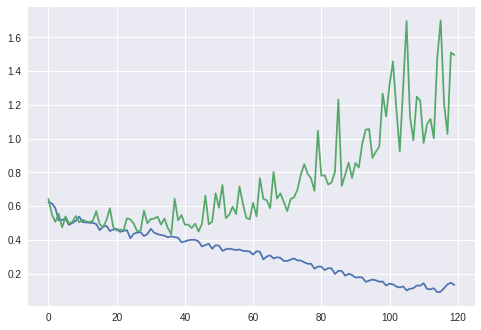

In [126]:
plt.plot(gru_forward_train_loss_history)
plt.plot(gru_forward_val_loss_history)

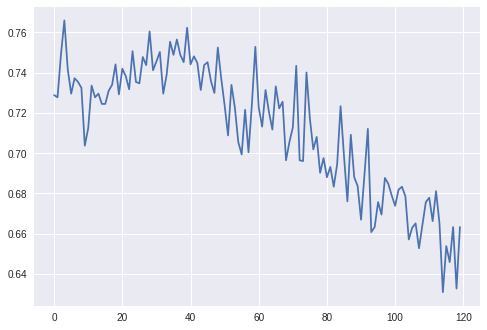

In [127]:
plt.plot(gru_forward_test_auc_history)

In [128]:
print("Best AUC: %.4f" % np.max([max(i) for i in gru_forward_test_auc_histories]))
print("Mean AUC: %.4f, Std: %.4f" % 
      (np.mean([max(i) for i in gru_forward_test_auc_histories]), 
       np.std([max(i) for i in gru_forward_test_auc_histories]))
     )

Best AUC: 0.7924
Mean AUC: 0.7733, Std: 0.0131


# GRU-Simple

In [0]:
def test_model_gru_simple(loader, model, concat_input=False):
    correct = 0
    total = 0
    model.eval()

    predictions = []
    truths = []
    
    total_loss = 0

    for data, label in loader:
        x, delta, m, x_forward, lengths = data

        sorted_lengths, sorted_idx = lengths.sort(descending=True)

        x = Variable(x[sorted_idx].float()).cuda()
        delta = Variable(delta[sorted_idx].float()).cuda()
        m = Variable(m[sorted_idx].float()).cuda()
        x_forward = Variable(x_forward[sorted_idx].float()).cuda()

        x[m.data.byte()] = 0.
        
        simple_input = torch.cat([x, m, delta], dim=-1)

        output = model(pack_padded_sequence(simple_input, sorted_lengths.numpy(), batch_first=True))
        
        label = label[sorted_idx]
        loss = loss_func(output, Variable(label).cuda())
            
        total_loss += loss.data[0]
        predicted = (output.cpu().max(1)[1].data.long()).view(-1)
        predictions += list(predicted.numpy())
        truths += list(label)
        total += label.size(0)
        correct += (predicted == label).sum()

    model.train()

    return 100 * correct / total, roc_auc_score(truths, predictions), total_loss/len(loader)

In [0]:
gru_simple_train_loss_histories = []
gru_simple_test_auc_histories = []
gru_simple_val_loss_histories = []
gru_simple_val_acc_histories = []

for k in range(num_fold):
    train_ds.set_active_indices(train_dfs[k])
    test_ds.set_active_indices(test_dfs[k], new_means=train_ds.means, new_stds=train_ds.stds)
    train_loader = torch.utils.data.DataLoader(dataset=train_ds,
                                           batch_size=batch_size,
                                           collate_fn=dataset.PhysioNET.collate_batch,
                                           shuffle=True)
    test_loader = torch.utils.data.DataLoader(dataset=test_ds,
                                          batch_size=batch_size,
                                          collate_fn=dataset.PhysioNET.collate_batch,
                                          shuffle=True)

    gru_simple = GRU_decoder(3*NUM_FEATURES, 43, output_size, 
                      gru_dropout, decoder_dropout)
    gru_simple.cuda()

    optimizer = torch.optim.Adam(gru_simple.parameters(), lr=1e-3)
    
    gru_simple_train_loss_history = []
    gru_simple_test_auc_history = []
    gru_simple_val_loss_history = []
    gru_simple_val_acc_history = []

    for epoch in range(60):
        start = time()
        total_loss = 0.

        for i, (data, label) in enumerate(train_loader):
            x, delta, m, x_forward, lengths = data

            sorted_lengths, sorted_idx = lengths.sort(descending=True)

            x = Variable(x[sorted_idx].float()).cuda()
            delta = Variable(delta[sorted_idx].float()).cuda()
            m = Variable(m[sorted_idx].float()).cuda()
            x_forward = Variable(x_forward[sorted_idx].float()).cuda()

            x[m.data.byte()] = 0.

            simple_input = torch.cat([x, m, delta], dim=-1)
            optimizer.zero_grad()
            output = gru_simple(pack_padded_sequence(simple_input, sorted_lengths.numpy(), batch_first=True))

            label = label[sorted_idx]
            loss = loss_func(output, Variable(label).cuda())
            loss.backward()
            optimizer.step()

            total_loss += loss.data[0]

            # report performance
            if (i + 1) % log_interval == 0:
                val_acc, test_auc, val_loss = test_model_gru_simple(test_loader, gru_simple, concat_input=True)
                gru_simple_train_loss_history.append(total_loss/(i+1))
                gru_simple_test_auc_history.append(test_auc)
                gru_simple_val_acc_history.append(val_acc)
                gru_simple_val_loss_history.append(val_loss)
                print('Fold: {8}, Epoch: [{0}/{1}], Step: [{2}/{3}], Loss: {4}, Validation Loss:{5}, Validation Acc:{6}, AUC:{7}'.format(
                    epoch + 1, num_epochs, i + 1, len(train_loader), total_loss/(i+1), val_loss, val_acc, test_auc, k+1))
        print("Epoch %d time: %.4f" % (epoch, time()-start))

    gru_simple_train_loss_histories.append(gru_simple_train_loss_history)
    gru_simple_test_auc_histories.append(gru_simple_test_auc_history)
    gru_simple_val_loss_histories.append(gru_simple_val_loss_history)
    gru_simple_val_acc_histories.append(gru_simple_val_acc_history)

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Fold: 1, Epoch: [1/40], Step: [9/29], Loss: 0.7008877860175239, Validation Loss:0.7109838724136353, Validation Acc:26.433915211970074, AUC:0.5051501035196688
Fold: 1, Epoch: [1/40], Step: [18/29], Loss: 0.7031718293825785, Validation Loss:0.6868892014026642, Validation Acc:44.13965087281795, AUC:0.5182971014492754
Fold: 1, Epoch: [1/40], Step: [27/29], Loss: 0.7012105915281508, Validation Loss:0.689066544175148, Validation Acc:45.13715710723192, AUC:0.5315734989648033
Epoch 0 time: 1.9704
Fold: 1, Epoch: [2/40], Step: [9/29], Loss: 0.6777586539586385, Validation Loss:0.6685870140790939, Validation Acc:50.37406483790524, AUC:0.5694875776397516
Fold: 1, Epoch: [2/40], Step: [18/29], Loss: 0.6744779480828179, Validation Loss:0.6709707230329514, Validation Acc:52.61845386533666, AUC:0.5675724637681159
Fold: 1, Epoch: [2/40], Step: [27/29], Loss: 0.669917243498343, Validation Loss:0.6614110618829727, Validation Acc:55.61097256857855, AUC:0.5924430641821947
Epoch 1 time: 1.8639
Fold: 1, Epoc

Fold: 1, Epoch: [12/40], Step: [18/29], Loss: 0.5880346894264221, Validation Loss:0.6345724612474442, Validation Acc:67.08229426433915, AUC:0.6591097308488613
Fold: 1, Epoch: [12/40], Step: [27/29], Loss: 0.5791966517766317, Validation Loss:0.6046360209584236, Validation Acc:63.84039900249377, AUC:0.6327898550724638
Epoch 11 time: 1.8776
Fold: 1, Epoch: [13/40], Step: [9/29], Loss: 0.5749481916427612, Validation Loss:0.6393613368272781, Validation Acc:66.83291770573567, AUC:0.6352225672877847
Fold: 1, Epoch: [13/40], Step: [18/29], Loss: 0.5706495940685272, Validation Loss:0.6284272521734238, Validation Acc:69.32668329177058, AUC:0.6347567287784679
Fold: 1, Epoch: [13/40], Step: [27/29], Loss: 0.5762844681739807, Validation Loss:0.6077932715415955, Validation Acc:74.06483790523691, AUC:0.6548136645962732
Epoch 12 time: 1.8521


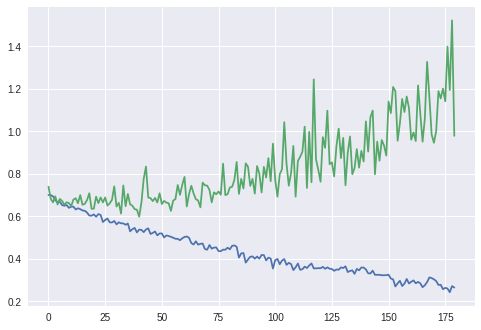

In [200]:
plt.plot(gru_simple_train_loss_history)
plt.plot(gru_simple_val_loss_history)

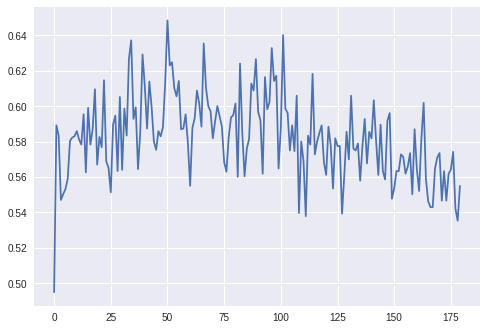

In [201]:
plt.plot(gru_simple_test_auc_history)

In [202]:
print("Best AUC: %.4f" % np.max([max(i) for i in gru_simple_test_auc_histories]))
print("Mean AUC: %.4f, Std: %.4f" % 
      (np.mean([max(i) for i in gru_simple_test_auc_histories]), 
       np.std([max(i) for i in gru_simple_test_auc_histories]))
     )

Best AUC: 0.7235
Mean AUC: 0.6755, Std: 0.0264


# GRU-D

In [0]:
def test_model_gru_d(loader, model):
    correct = 0
    total = 0
    model.eval()

    predictions = []
    truths = []
    
    total_loss = 0

    for data, label in loader:
        x, delta, m, x_forward, lengths = data

        sorted_lengths, sorted_idx = lengths.sort(descending=True)

        x = Variable(x[sorted_idx].float()).cuda()
        delta = Variable(delta[sorted_idx].float()).cuda()
        m = Variable(m[sorted_idx].float()).cuda()
        x_forward = Variable(x_forward[sorted_idx].float()).cuda()

        dummy = pack_padded_sequence(x, sorted_lengths.numpy(), batch_first=True)

        output, hidden = gru_d(x, delta, m, x_forward, dummy.batch_sizes)

        label = label[sorted_idx]
        loss = loss_func(output, Variable(label).cuda())

        total_loss += loss.data[0]
        predicted = (output.cpu().max(1)[1].data.long()).view(-1)
#         predicted = ((output.cpu().data > 0.5).long()).view(-1)
        predictions += list(predicted.numpy())
        truths += list(label.numpy())
        total += label.size(0)
        correct += (predicted == label).sum()

    model.train()

    return 100 * correct / total, roc_auc_score(truths, predictions), total_loss/len(loader)

In [0]:
class GRUD(nn.Module):
    def __init__(self, input_size, hidden_size, output_size,
                 gru_dropout=0.3, decoder_dropout=0.5, batch_first=True):
        super(GRUD, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.batch_first = batch_first
#         self.feature_means = Variable(torch.FloatTensor(feature_means), requires_grad=False)
        # initialize weights and biases
        self.W_r = nn.Parameter(torch.FloatTensor(input_size, hidden_size).normal_(0, 0.02))
        self.U_r = nn.Parameter(torch.FloatTensor(hidden_size, hidden_size).normal_(0, 0.02))
        self.V_r = nn.Parameter(torch.FloatTensor(input_size, hidden_size).normal_(0, 0.02))
        self.b_r = nn.Parameter(torch.FloatTensor(hidden_size).zero_())

        self.W_z = nn.Parameter(torch.FloatTensor(input_size, hidden_size).normal_(0, 0.02))
        self.U_z = nn.Parameter(torch.FloatTensor(hidden_size, hidden_size).normal_(0, 0.02))
        self.V_z = nn.Parameter(torch.FloatTensor(input_size, hidden_size).normal_(0, 0.02))
        self.b_z = nn.Parameter(torch.FloatTensor(hidden_size).zero_())

        self.W = nn.Parameter(torch.FloatTensor(input_size, hidden_size).normal_(0, 0.02))
        self.U = nn.Parameter(torch.FloatTensor(hidden_size, hidden_size).normal_(0, 0.02))
        self.V = nn.Parameter(torch.FloatTensor(input_size, hidden_size).normal_(0, 0.02))
        self.b = nn.Parameter(torch.FloatTensor(hidden_size).zero_())

        # since W_gamma_x is diagonal, just initialize 1-d
        self.W_gamma_x = nn.Parameter(torch.FloatTensor(input_size).normal_(0, 0.02))
        self.b_gamma_x = nn.Parameter(torch.FloatTensor(input_size).zero_())

        self.W_gamma_h = nn.Parameter(torch.FloatTensor(input_size, hidden_size).normal_(0, 0.02))
        self.b_gamma_h = nn.Parameter(torch.FloatTensor(hidden_size).zero_())
        self.gru_dropout = gru_dropout
        
        self.decoder = nn.Linear(hidden_size, output_size)
        self.bn = nn.BatchNorm1d(hidden_size)
        self.decoder_dropout = nn.Dropout(p=decoder_dropout)
        
    def forward(self, x, delta, m, x_forward, batch_sizes, h_t=None):
        """
        
        :param x: features input [batch_size, seq_len, num_features]
        :param delta: time interval of feature observation [batch_size, seq_len, num_features]
        :param m: masking vector {0, 1} of [batch_size, seq_len, num_features]
        :param x_forward: place to replace missing values with [b, seqlen, numf]
        :param h_t: initial hidden state [batch_size, seq_len, hidden_size]
        :return: output [batch_size, output_size], hidden_state [batch_size, hidden_size]
        """
        batch_size, seq_len, input_size = x.size()
        if h_t is None:
            # initialize to zero
            h_t = Variable(torch.FloatTensor(batch_size, self.hidden_size).zero_())
            if x.is_cuda:
                h_t = h_t.cuda()
          
        # compute decays
        decay_x = delta*self.W_gamma_x + self.b_gamma_x
        zeroes = Variable(torch.zeros(decay_x.size()))
        if decay_x.is_cuda:
            zeroes = zeroes.cuda()
        gamma_x_t = torch.exp(-torch.max(zeroes, decay_x))
            
        decay_h = torch.matmul(m, self.W_gamma_h) + self.b_gamma_h
        zeroes = Variable(torch.zeros(decay_h.size()))
        if decay_h.is_cuda:
            zeroes = zeroes.cuda()
        gamma_x_h = torch.exp(-torch.max(zeroes, decay_h))
            
        # replace missing values
        x_replace = decay_x * x_forward + (1-decay_x) * 0.001
        x[m.byte()] = x_replace[m.byte()]
                  
        # dropout masks, one for each batch
        dropout_rate = self.gru_dropout if self.training else 0.
        
        W_dropout = Variable((torch.FloatTensor(self.W.size()).uniform_() > dropout_rate).float())
        U_dropout = Variable((torch.FloatTensor(self.U.size()).uniform_() > dropout_rate).float())
        V_dropout = Variable((torch.FloatTensor(self.V.size()).uniform_() > dropout_rate).float())
        
        if decay_h.is_cuda:
            W_dropout = W_dropout.cuda()
            U_dropout = U_dropout.cuda()
            V_dropout = V_dropout.cuda()
        
        for t in range(seq_len):
            # decay h
            update_range = Variable(torch.LongTensor(list(range(batch_sizes[t]))))
            if decay_h.is_cuda:
                update_range = update_range.cuda()
            h_t = h_t.clone().index_copy_(0, update_range, gamma_x_h[:batch_sizes[t],t,:] * h_t[:batch_sizes[t]])

            z_t = F.sigmoid(torch.matmul(x[:batch_sizes[t], t, :], self.W_z) + torch.matmul(h_t[:batch_sizes[t]], self.U_z) + torch.matmul(1-m[:batch_sizes[t], t, :], self.V_z) + self.b_z)
            r_t = F.sigmoid(torch.matmul(x[:batch_sizes[t], t, :], self.W_r) + torch.matmul(h_t[:batch_sizes[t]], self.U_r) + torch.matmul(1-m[:batch_sizes[t], t, :], self.V_r) + self.b_r)
            h_tilde_t = F.tanh(torch.matmul(x[:batch_sizes[t], t, :], self.W*W_dropout) + torch.matmul(h_t[:batch_sizes[t]]*r_t, self.U*U_dropout) + torch.matmul(1-m[:batch_sizes[t], t, :], self.V*V_dropout) + self.b)
            h_t = h_t.clone()
            h_t = h_t.clone().index_copy_(0, update_range, (1 - z_t) * h_t[:batch_sizes[t]] + z_t * h_tilde_t)
            
        if batch_size > 1:
            h_t = self.bn(h_t)

        output = F.log_softmax(self.decoder(self.decoder_dropout(h_t)), dim=-1)
        
        return output, h_t


In [0]:

gru_d = GRUD(NUM_FEATURES, 49, output_size, 
                      gru_dropout, decoder_dropout)
gru_d.cuda()

optimizer = torch.optim.Adam(gru_d.parameters(), lr=1e-3)

In [0]:
gru_d_train_loss_histories = []
gru_d_test_auc_histories = []
gru_d_val_loss_histories = []
gru_d_val_acc_histories = []

for k in range(num_fold):
    train_ds.set_active_indices(train_dfs[k])
    test_ds.set_active_indices(test_dfs[k], new_means=train_ds.means, new_stds=train_ds.stds)
    train_loader = torch.utils.data.DataLoader(dataset=train_ds,
                                           batch_size=batch_size,
                                           collate_fn=dataset.PhysioNET.collate_batch,
                                           shuffle=True)
    test_loader = torch.utils.data.DataLoader(dataset=test_ds,
                                          batch_size=batch_size,
                                          collate_fn=dataset.PhysioNET.collate_batch,
                                          shuffle=True)

    gru_d = GRUD(NUM_FEATURES, 49, output_size, 
                      0.0, decoder_dropout)
    gru_d.cuda()

    optimizer = torch.optim.Adam(gru_d.parameters(), lr=1e-3)

    gru_d_train_loss_history = []
    gru_d_test_auc_history = []
    gru_d_val_loss_history = []
    gru_d_val_acc_history = []

    for epoch in range(num_epochs):
        start = time()
        total_loss = 0.

        for i, (data, label) in enumerate(train_loader):
            x, delta, m, x_forward, lengths = data

            sorted_lengths, sorted_idx = lengths.sort(descending=True)

            x = Variable(x[sorted_idx].float()).cuda()
            delta = Variable(delta[sorted_idx].float()).cuda()
            m = Variable(m[sorted_idx].float()).cuda()
            x_forward = Variable(x_forward[sorted_idx].float()).cuda()
            
            dummy = pack_padded_sequence(x, sorted_lengths.numpy(), batch_first=True)
            optimizer.zero_grad()
            
            output, hidden = gru_d(x, delta, m, x_forward, torch.LongTensor(dummy.batch_sizes).cuda())

            label = label[sorted_idx]
            loss = loss_func(output, Variable(label).cuda())
            loss.backward()
            optimizer.step()

            total_loss += loss.data[0]

            # report performance
            if (i + 1) % log_interval == 0:
                val_acc, test_auc, val_loss = test_model_gru_d(test_loader, gru_d)
                gru_d_train_loss_history.append(total_loss/(i+1))
                gru_d_test_auc_history.append(test_auc)
                gru_d_val_acc_history.append(val_acc)
                gru_d_val_loss_history.append(val_loss)
                print('Fold: {8}, Epoch: [{0}/{1}], Step: [{2}/{3}], Loss: {4}, Validation Loss:{5}, Validation Acc:{6}, AUC:{7}'.format(
                    epoch + 1, num_epochs, i + 1, len(train_loader), total_loss/(i+1), val_loss, val_acc, test_auc, k+1))
#         print("Epoch %d time: %.4f" % (epoch, time()-start))
    gru_d_train_loss_histories.append(gru_d_train_loss_history)
    gru_d_test_auc_histories.append(gru_d_test_auc_history)
    gru_d_val_loss_histories.append(gru_d_val_loss_history)
    gru_d_val_acc_histories.append(gru_d_val_acc_history)

Fold: 1, Epoch: [1/40], Step: [9/29], Loss: 0.6582479808065627, Validation Loss:0.6737809181213379, Validation Acc:72.31920199501246, AUC:0.6970238095238096
Fold: 1, Epoch: [1/40], Step: [18/29], Loss: 0.6587927374574873, Validation Loss:0.6195915043354034, Validation Acc:61.596009975062344, AUC:0.6870600414078675


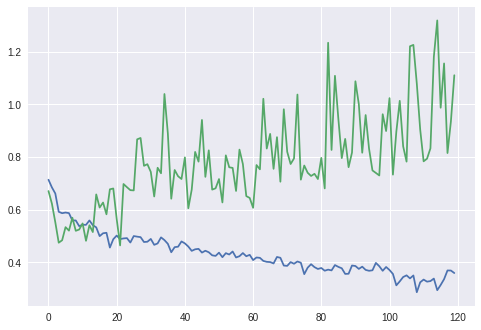

In [216]:
plt.plot(gru_d_train_loss_history)
plt.plot(gru_d_val_loss_history)

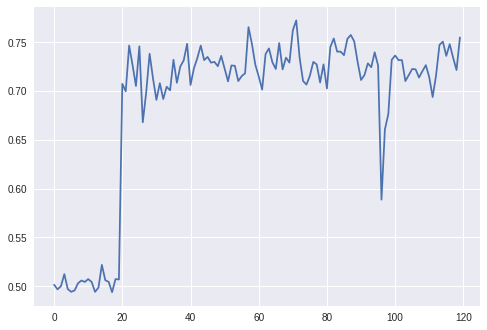

In [151]:
plt.plot(gru_d_test_auc_history)

In [215]:
print("Best AUC: %.4f" % np.max([max(i) for i in gru_d_test_auc_histories]))
print("Mean AUC: %.4f, Std: %.4f" % 
      (np.mean([max(i) for i in gru_d_test_auc_histories]), 
       np.std([max(i) for i in gru_d_test_auc_histories]))
     )

Best AUC: 0.7892
Mean AUC: 0.7892, Std: 0.0000
